# Hopefully the FINAL notebook I'll need

In [1]:
import pandas as pd
import glob
import os
import numpy as np

In [7]:
def merge_csv_files(folder_path, output_file="merged.csv"):
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df.columns = [col.strip() for col in df.columns]
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)

# Use correct relative path for CICIDS2017 folder
merge_csv_files("../CICIDS2017", "merged.csv")

need to get this part to only include the top 50 features:

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# SETTINGS
# ----------------------------
file_path = "merged.csv"
fraction = 0.90     # % of data to sample overall (keeps earliest fraction, preserves timeline)
seq_length = 10     # default LSTM sequence length (adjust as needed)

# ----------------------------
# 1) Load in chunks (preserve order)
# ----------------------------
chunks = []
chunk_size = 10_000
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Strip whitespace from column names
    chunk.columns = chunk.columns.str.strip()

    # Downcast numerics
    for col in chunk.select_dtypes(include=['int', 'float']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')

    # Replace NaN/Inf inside chunk
    chunk = chunk.replace([np.inf, -np.inf], np.nan).fillna(0)

    chunks.append(chunk)

data = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ----------------------------
# 2) Label to binary
# ----------------------------
if "Label" not in data.columns:
    raise KeyError("Expected a 'Label' column.")

data["Label"] = data["Label"].apply(
    lambda x: 0 if str(x).strip().upper() == "BENIGN" else 1
).astype(np.int32)

# ----------------------------
# 3) Optional overall fraction (preserves order)
# ----------------------------
if fraction < 1.0:
    n_sample = max(1, int(len(data) * fraction))
    data = data.iloc[:n_sample].copy()

# ----------------------------
# 4) Time-aware benign downsampling (keeps chronology)
# ----------------------------
def time_aware_downsample_benign(df, label_col="Label", max_benign_ratio=0.55):
    keep_mask = np.zeros(len(df), dtype=bool)
    benign_kept = 0
    attack_kept = 0

    label = df[label_col].to_numpy()

    for i in range(len(df)):
        if label[i] == 1:
            keep_mask[i] = True
            attack_kept += 1
        else:
            proposed_benign = benign_kept + 1
            proposed_total  = proposed_benign + attack_kept
            if proposed_total == 0:
                keep_mask[i] = True
                benign_kept += 1
            else:
                if (proposed_benign / proposed_total) <= max_benign_ratio:
                    keep_mask[i] = True
                    benign_kept += 1

    kept = df.loc[keep_mask]
    return kept

# Apply chronology-safe downsampling
data = time_aware_downsample_benign(data, label_col="Label", max_benign_ratio=0.55).reset_index(drop=True)

# ----------------------------
# 5) Cap extreme values (exclude the label)
# ----------------------------
numeric_cols = [c for c in data.select_dtypes(include=[np.number]).columns if c != "Label"]
for col in numeric_cols:
    cap_value = data[col].quantile(0.999)
    data[col] = np.clip(data[col], a_min=None, a_max=cap_value)

# ----------------------------
# 6) Feature selection: keep only TOP 50 features
# ----------------------------
X = data.drop(columns=["Label"])
y = data["Label"]

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(50).index.tolist()

print("\nTop 50 selected features:")
print(top_features)

data = data[top_features + ["Label"]]

# ----------------------------
# 7) Dtypes for ML (features float32, label int32)
# ----------------------------
for col in top_features:
    data[col] = data[col].astype(np.float32)
data["Label"] = data["Label"].astype(np.int32)

# ----------------------------
# Save final reduced dataset
# ----------------------------
data.to_csv("new_merged.csv", index=False)

# ----------------------------
# Final assignment for downstream code
# ----------------------------
datadf = data.copy()
ftnames = [c.strip() for c in datadf.columns if c.strip() != "Label"]

print(f"\nFinal shape: {datadf.shape}")
print(f"Number of features: {len(ftnames)}")
print("First few feature names:", ftnames[:10])
print("Label distribution:\n", datadf['Label'].value_counts())

# ======================================================================
# Chronology-safe sequence utilities (NO shuffling, NO stratify anywhere)
# ======================================================================

def create_sequences(X, y, sequence_length=10, label_strategy='last'):
    """
    Create overlapping sequences without breaking chronology.
    label_strategy: 'last' | 'majority' | 'any_attack'
    """
    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"[create_sequences] Adjusted sequence_length to {sequence_length}")

    X_sequences, y_sequences = [], []
    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i+sequence_length]
        y_seq = y[i:i+sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > (len(y_seq) // 2) else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if (y_seq == 1).any() else 0)
        else:
            raise ValueError(f"Unknown label_strategy: {label_strategy}")

    X_sequences = np.asarray(X_sequences, dtype=np.float32)
    y_sequences = np.asarray(y_sequences, dtype=np.float32)

    return X_sequences, y_sequences

def chrono_split_train_val_test(df, label_col="Label", train_ratio=0.7, val_ratio=0.15):
    """
    Chronological split on rows (NO shuffle). Test gets the tail.
    """
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_df = df.iloc[:n_train]
    val_df   = df.iloc[n_train:n_train+n_val]
    test_df  = df.iloc[n_train+n_val:]

    def xy(d):
        X = d.drop(columns=[label_col]).to_numpy(dtype=np.float32)
        y = d[label_col].to_numpy(dtype=np.int32)
        return X, y

    return xy(train_df), xy(val_df), xy(test_df)

def build_chrono_sequences(df, label_col="Label", sequence_length=10, label_strategy='last'):
    """
    Split chronologically on raw rows, then build sequences inside each split so
    no sequence crosses split boundaries.
    """
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = chrono_split_train_val_test(df, label_col=label_col)

    X_train_seq, y_train_seq = create_sequences(X_tr, y_tr, sequence_length, label_strategy)
    X_val_seq,   y_val_seq   = create_sequences(X_va, y_va, sequence_length, label_strategy)
    X_test_seq,  y_test_seq  = create_sequences(X_te, y_te, sequence_length, label_strategy)

    # Quick sanity print
    def _dist(y):
        c = Counter(y.astype(int).tolist())
        total = len(y)
        if total == 0:
            return {}
        return {k: f"{v} ({v/total:.2%})" for k, v in sorted(c.items())}

    print("\n=== Chronological split (sequence-level) ===")
    print(f"Train seq: {X_train_seq.shape}, dist: { _dist(y_train_seq) }")
    print(f"Val   seq: {X_val_seq.shape}, dist: { _dist(y_val_seq) }")
    print(f"Test  seq: {X_test_seq.shape}, dist: { _dist(y_test_seq) }")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq


Top 50 selected features:
['Destination Port', 'Init_Win_bytes_forward', 'Min Packet Length', 'Average Packet Size', 'Max Packet Length', 'Subflow Fwd Bytes', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Fwd Packet Length Max', 'Bwd Packet Length Std', 'Init_Win_bytes_backward', 'Avg Fwd Segment Size', 'Total Length of Fwd Packets', 'Packet Length Std', 'Total Length of Bwd Packets', 'Packet Length Mean', 'Packet Length Variance', 'Avg Bwd Segment Size', 'Fwd Packet Length Min', 'Bwd Header Length', 'Total Fwd Packets', 'Fwd Header Length.1', 'Fwd Header Length', 'Subflow Bwd Bytes', 'Bwd Packets/s', 'URG Flag Count', 'Fwd IAT Min', 'Fwd IAT Std', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Duration', 'Fwd IAT Total', 'Total Backward Packets', 'Subflow Bwd Packets', 'Fwd IAT Mean', 'Fwd Packet Length Std', 'act_data_pkt_fwd', 'Flow IAT Std', 'Flow Bytes/s', 'Idle Min', 'Idle Max', 'min_seg_size_forward', 'Bwd IAT Max', 'Bwd IA

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import optuna
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
def print_data_info(X, y, stage_name):
    """Print comprehensive data information"""
    print(f"\n=== {stage_name} Data Info ===")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Feature data type: {X.dtype}")
    print(f"Label data type: {y.dtype}")
    
    # Check for NaN/inf values
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
    print(f"NaN values in features: {nan_count}")
    print(f"Inf values in features: {inf_count}")
    
    # Basic statistics
    print(f"Feature matrix - Min: {X.min():.4f}, Max: {X.max():.4f}, Mean: {X.mean():.4f}")
    
    # Label distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Label distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(y)) * 100
        print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Sample some labels
    print(f"First 20 labels: {y[:20]}")
    print(f"Last 20 labels: {y[-20:]}")

def validate_data_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate that data splits preserve class distribution"""
    print("\n=== Data Split Validation ===")
    
    # Check shapes
    print(f"Original total samples: {len(X_train) + len(X_val) + len(X_test)}")
    print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Val: {X_val.shape[0]} ({X_val.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    
    # Check class distributions
    datasets = [("Train", y_train), ("Val", y_val), ("Test", y_test)]
    
    print("\nClass distributions across splits:")
    for name, y_split in datasets:
        unique_labels, counts = np.unique(y_split, return_counts=True)
        print(f"{name}:")
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(y_split)) * 100
            print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Check for data leakage indicators
    print(f"\nFeature statistics consistency check:")
    print(f"Train mean: {X_train.mean():.6f}")
    print(f"Val mean: {X_val.mean():.6f}")
    print(f"Test mean: {X_test.mean():.6f}")

def check_preprocessing_integrity(X_before, y_before, X_after, y_after, stage_name):
    """Check if preprocessing preserved data integrity"""
    print(f"\n=== {stage_name} Preprocessing Integrity Check ===")
    
    # Shape consistency
    assert X_before.shape[0] == X_after.shape[0], f"Sample count mismatch: {X_before.shape[0]} vs {X_after.shape[0]}"
    assert len(y_before) == len(y_after), f"Label count mismatch: {len(y_before)} vs {len(y_after)}"
    print("✓ Sample counts preserved")
    
    # Label consistency
    assert np.array_equal(y_before, y_after), "Labels were modified during preprocessing!"
    print("✓ Labels preserved")
    
    # Feature scaling check
    if stage_name == "Scaling":
        print(f"Before scaling - Min: {X_before.min():.4f}, Max: {X_before.max():.4f}")
        print(f"After scaling - Min: {X_after.min():.4f}, Max: {X_after.max():.4f}")
        print(f"After scaling - Mean: {X_after.mean():.6f}, Std: {X_after.std():.6f}")


In [5]:
class BaselineEvaluator:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def add_dummy_classifier(self, X_train, y_train):
        """Add majority class predictor"""
        print("Adding Majority Class Predictor...")
        self.models['majority_class'] = DummyClassifier(strategy='most_frequent', random_state=42)
        self.models['majority_class'].fit(X_train, y_train)
    
    def add_logistic_regression(self, X_train, y_train):
        """Add logistic regression baseline"""
        print("Adding Logistic Regression...")
        self.models['logistic_regression'] = LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'
        )
        self.models['logistic_regression'].fit(X_train, y_train)
    
    def add_random_forest(self, X_train, y_train):
        """Add random forest baseline"""
        print("Adding Random Forest...")
        self.models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        self.models['random_forest'].fit(X_train, y_train)
    
    def add_knn(self, X_train, y_train):
        """Add KNN baseline"""
        print("Adding KNN...")
        # Use smaller sample for KNN if dataset is too large
        if len(X_train) > 10000:
            print(f"Using subset of {min(5000, len(X_train))} samples for KNN training...")
            indices = np.random.choice(len(X_train), min(5000, len(X_train)), replace=False)
            X_train_knn = X_train[indices]
            y_train_knn = y_train[indices]
        else:
            X_train_knn = X_train
            y_train_knn = y_train
            
        self.models['knn'] = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        self.models['knn'].fit(X_train_knn, y_train_knn)
    
    def evaluate_all(self, X_test, y_test, model_name_prefix="Baseline"):
        """Evaluate all baseline models"""
        print(f"\n=== {model_name_prefix} Model Evaluation ===")
        
        for name, model in self.models.items():
            print(f"\nEvaluating {name.replace('_', ' ').title()}...")
            
            # Predictions
            try:
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
            except Exception as e:
                print(f"Error with {name}: {e}")
                continue
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # AUC calculation
            try:
                if len(np.unique(y_test)) > 1:
                    auc = roc_auc_score(y_test, y_prob)
                    pr_auc = average_precision_score(y_test, y_prob)
                else:
                    auc = pr_auc = 0.5
            except:
                auc = pr_auc = 0.5
            
            # Store results
            self.results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'pr_auc': pr_auc,
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            
            # Print results
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1 Score:  {f1:.4f}")
            print(f"  AUC:       {auc:.4f}")
            print(f"  PR-AUC:    {pr_auc:.4f}")
    
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models with robust error handling"""
        n_models = len(self.results)  # Use results, not models
        if n_models == 0:
            print("No model results available for confusion matrix plotting")
            return
        
        print(f"Plotting confusion matrices for {n_models} models...")
        
        # Try the subplot approach first
        try:
            cols = min(3, n_models)
            rows = (n_models + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            
            # Convert to 2D array for consistent indexing
            if n_models == 1:
                axes = np.array([[axes]])
            elif rows == 1:
                axes = axes.reshape(1, -1)
            elif cols == 1:
                axes = axes.reshape(-1, 1)
            
            plot_idx = 0
            for name, results in self.results.items():
                try:
                    row = plot_idx // cols
                    col = plot_idx % cols
                    
                    ax = axes[row, col]
                    
                    cm = confusion_matrix(y_test, results['y_pred'])
                    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
                    ax.set_title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('Actual')
                    
                    plot_idx += 1
                    
                except Exception as e:
                    print(f"Error plotting confusion matrix for {name}: {e}")
                    plot_idx += 1
                    continue
            
            # Hide empty subplots
            for idx in range(n_models, rows * cols):
                try:
                    row = idx // cols
                    col = idx % cols
                    axes[row, col].axis('off')
                except:
                    continue
            
            plt.tight_layout()
            plt.show()
            print("✅ Confusion matrices plotted successfully")
            
        except Exception as e:
            print(f"Subplot approach failed: {e}")
            print("Falling back to individual plots...")
            
            # Fallback: individual plots
            try:
                for name, results in self.results.items():
                    try:
                        plt.figure(figsize=(6, 4))
                        cm = confusion_matrix(y_test, results['y_pred'])
                        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                        plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                        plt.xlabel('Predicted')
                        plt.ylabel('Actual')
                        plt.tight_layout()
                        plt.show()
                        print(f"✅ Confusion matrix for {name} plotted")
                    except Exception as e2:
                        print(f"❌ Failed to plot confusion matrix for {name}: {e2}")
                        
            except Exception as e3:
                print(f"❌ All plotting approaches failed: {e3}")
                print("Skipping confusion matrix plots...")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            print("No results available for summary")
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)
    
    # Replace your plot_confusion_matrices method with this simple version
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models - Simple version"""
        if not self.results:
            print("No results available for plotting")
            return
        
        print(f"Plotting confusion matrices for {len(self.results)} models...")
        
        # Use simple individual plots to avoid matplotlib axes issues
        for name, results in self.results.items():
            try:
                print(f"Plotting confusion matrix for {name}...")
                
                # Create a new figure for each model
                plt.figure(figsize=(6, 5))
                
                # Calculate confusion matrix
                cm = confusion_matrix(y_test, results['y_pred'])
                
                # Use matplotlib directly instead of seaborn to avoid axes issues
                plt.imshow(cm, interpolation='nearest', cmap='Blues')
                plt.colorbar()
                
                # Add text annotations
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, str(cm[i, j]), 
                                ha='center', va='center', 
                                color='white' if cm[i, j] > cm.max() / 2 else 'black',
                                fontsize=14, fontweight='bold')
                
                # Labels and title
                plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}', 
                        fontsize=12, pad=20)
                plt.xlabel('Predicted Label', fontsize=11)
                plt.ylabel('True Label', fontsize=11)
                
                # Set tick labels
                tick_labels = ['Benign', 'Attack']
                plt.xticks(range(len(tick_labels)), tick_labels)
                plt.yticks(range(len(tick_labels)), tick_labels)
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error plotting confusion matrix for {name}: {e}")
                # Still try to show basic metrics
                try:
                    cm = confusion_matrix(y_test, results['y_pred'])
                    print(f"  Confusion Matrix for {name}:")
                    print(f"    {cm}")
                except:
                    print(f"  Could not generate any visualization for {name}")
        
        print("✅ Confusion matrix plotting completed")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)

In [6]:
SEQ_LENGTH = 10

In [7]:
from collections import Counter
import numpy as np

# ==========================================================
# Chronology-safe prepare_lstm_sequences_fixed
# ==========================================================
def prepare_lstm_sequences_fixed(X, y, sequence_length=SEQ_LENGTH, label_strategy='majority'):
    """
    Convert tabular data to sequences for LSTM training with better label handling.
    Chronology preserved (NO shuffling).
    """
    print(f"Creating sequences of length {sequence_length} with {label_strategy} labeling...")

    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"Adjusted sequence length to {sequence_length} due to limited data")

    X_sequences = []
    y_sequences = []

    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i + sequence_length]
        y_seq = y[i:i + sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > len(y_seq) // 2 else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if np.any(y_seq == 1) else 0)

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.int32)

    print(f"Created {len(X_sequences)} sequences")
    print(f"Sequence shape: {X_sequences.shape}")

    # Distribution debug
    original_dist = Counter(y)
    sequence_dist = Counter(y_sequences)
    print(f"Original distribution: {dict(original_dist)}")
    print(f"Sequence distribution: {dict(sequence_dist)}")

    return X_sequences, y_sequences


# ==========================================================
# Chronology-safe create_stratified_sequences
# (renamed internally but kept external name)
# ==========================================================
def create_stratified_sequences(X, y, sequence_length=SEQ_LENGTH, test_size=0.4, val_split=0.5, random_state=42):
    """
    Chronology-safe split of sequences (replaces stratified split).
    """
    print("Creating chronology-safe sequences (no stratify)...")

    # Step 1: build sequences
    X_seq, y_seq = prepare_lstm_sequences_fixed(X, y, sequence_length, label_strategy='majority')

    # Step 2: split chronologically
    n_total = len(X_seq)
    n_test = int(n_total * test_size)
    n_val = int((n_total - n_test) * val_split)

    train_end = n_total - n_test - n_val
    val_end   = n_total - n_test

    X_train_seq, y_train_seq = X_seq[:train_end], y_seq[:train_end]
    X_val_seq,   y_val_seq   = X_seq[train_end:val_end], y_seq[train_end:val_end]
    X_test_seq,  y_test_seq  = X_seq[val_end:], y_seq[val_end:]

    validate_sequence_splits(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq)

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq


# ==========================================================
# validate_sequence_splits (unchanged, still works)
# ==========================================================
def validate_sequence_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate sequence splits maintain reasonable class distribution"""
    print("\n=== Sequence Split Validation ===")
    splits = [("Train", y_train), ("Val", y_val), ("Test", y_test)]

    for name, y_split in splits:
        if len(y_split) > 0:
            attack_ratio = np.sum(y_split) / len(y_split)
            benign_count = len(y_split) - np.sum(y_split)
            attack_count = np.sum(y_split)
            print(f"{name}: {benign_count} benign, {attack_count} attack (ratio: {attack_ratio:.3f})")
        else:
            print(f"{name}: Empty split!")


# ==========================================================
# get_balanced_class_weights (no change needed)
# ==========================================================
def get_balanced_class_weights(y_train):
    """Calculate balanced class weights with safety checks"""
    class_counts = Counter(y_train)
    print(f"Training class counts: {dict(class_counts)}")

    if len(class_counts) < 2:
        print("⚠️  WARNING: Only one class in training data!")
        return {0: 1.0, 1: 1.0}

    total_samples = len(y_train)
    n_classes = len(class_counts)
    class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}

    print(f"Calculated class weights: {class_weights}")
    return class_weights


In [8]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3, 
                 use_attention=True, bidirectional=True):
        super().__init__()
        
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        print(f"Initializing AdvancedLSTM:")
        print(f"  Input dim: {input_dim}")
        print(f"  Hidden dim: {hidden_dim}")
        print(f"  Num layers: {num_layers}")
        print(f"  Dropout: {dropout}")
        print(f"  Attention: {use_attention}")
        print(f"  Bidirectional: {bidirectional}")
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Attention mechanism
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=4,
                dropout=dropout,
                batch_first=True
            )
        
        # Classification head with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        
    def forward(self, x, return_features=False):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        if self.use_attention:
            # Apply attention to all time steps
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # Use mean of attended outputs
            features = attended_out.mean(dim=1)
        else:
            # Use last time step
            features = lstm_out[:, -1, :]

        if return_features:
            return features  # Return the hidden layer values (pre-classifier)
        
        # Classification
        logits = self.classifier(features)
        
        return logits.squeeze(-1)

In [9]:
def train_advanced_lstm_enhanced(X_train, y_train, X_val, y_val, params, model, epochs=30, min_delta=1e-4):
    """
    Enhanced training with better overfitting prevention and chronology preservation.
    """
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    import numpy as np
    from collections import Counter
    from sklearn.metrics import roc_auc_score, f1_score

    # Ensure float32 for GPU efficiency
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    # Prepare datasets with NO shuffling (chronology preserved)
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling to preserve chronology
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    # Optimizer with stronger weight decay if specified
    weight_decay = params.get('l2_reg', 1e-5)
    if params.get('optimizer') == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=weight_decay
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=params['lr'],
            weight_decay=weight_decay
        )

    # Conservative learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',  # Monitor validation F1 (maximize)
        factor=0.5,  # Reduce LR by half
        patience=params.get('reduce_lr_patience', 3),
        verbose=True,
        min_lr=params.get('min_lr', 1e-6)
    )

    # Loss function with class balancing
    device = next(model.parameters()).device
    class_counts = Counter(y_train)
    
    if len(class_counts) > 1:
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
        print(f"Using pos_weight: {pos_weight.item():.3f} (Benign/Attack ratio)")
    else:
        pos_weight = torch.tensor([1.0], device=device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training monitoring
    train_losses, val_aucs, val_f1s = [], [], []
    best_val_f1 = 0
    best_model_state = None
    patience = params.get('early_stopping_patience', 3)
    patience_counter = 0
    
    # Overfitting detection variables
    consecutive_loss_drops = 0
    loss_drop_threshold = 0.9  # If loss drops by 90% in one epoch, flag it

    print(f"Training for max {epochs} epochs with early stopping (patience={patience})")
    print(f"Batch size: {params['batch_size']}, Learning rate: {params['lr']}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)

            # Primary loss
            loss = criterion(outputs, batch_y)
            
            # L2 regularization (if not using weight_decay in optimizer)
            if params.get('l2_reg', 0) > 0 and params.get('optimizer') != 'adamw':
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += params['l2_reg'] * l2_norm

            loss.backward()
            
            # Gradient clipping
            clip_value = params.get('gradient_clip', 1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)

        # Overfitting detection: Check for suspiciously fast loss drops
        if epoch > 0:
            loss_drop_ratio = (train_losses[-2] - avg_train_loss) / train_losses[-2]
            if loss_drop_ratio > loss_drop_threshold:
                consecutive_loss_drops += 1
                print(f"WARNING: Large loss drop detected: {loss_drop_ratio:.1%}")
                if consecutive_loss_drops >= 2:
                    print("ALERT: Multiple consecutive large loss drops - possible overfitting!")
            else:
                consecutive_loss_drops = 0

        # Validation phase
        model.eval()
        val_probs, val_targets = [], []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                
                # Check for NaN outputs
                if torch.isnan(outputs).any():
                    print(f"WARNING: NaN detected in outputs at epoch {epoch+1}")
                    continue
                
                val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(batch_y.numpy())

        if len(val_probs) == 0:
            print(f"ERROR: No valid validation predictions at epoch {epoch+1}")
            break

        val_probs = np.array(val_probs)
        val_targets = np.array(val_targets)

        # Calculate validation metrics
        if len(np.unique(val_targets)) > 1:
            val_auc = roc_auc_score(val_targets, val_probs)
        else:
            val_auc = 0.5
            print(f"WARNING: Only one class in validation set at epoch {epoch+1}")

        # Find best F1 threshold
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []
        for t in thresholds:
            try:
                f1 = f1_score(val_targets, (val_probs >= t).astype(int), zero_division=0)
                f1_scores.append(f1)
            except:
                f1_scores.append(0.0)
        
        best_f1 = max(f1_scores) if f1_scores else 0.0
        val_aucs.append(val_auc)
        val_f1s.append(best_f1)

        # Early stopping logic
        if best_f1 > best_val_f1 + min_delta:
            best_val_f1 = best_f1
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        # Step the scheduler (monitoring validation F1)
        scheduler.step(best_f1)

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        # Progress reporting
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val F1: {best_f1:.4f} | "
              f"Val AUC: {val_auc:.4f} | "
              f"LR: {current_lr:.2e}")

        # Additional overfitting warnings
        if epoch >= 5 and best_f1 > 0.995:
            print("WARNING: Suspiciously high validation F1 (>99.5%) - check for data leakage!")
        
        if epoch >= 3 and avg_train_loss < 0.01:
            print("WARNING: Very low training loss - possible overfitting")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")
    else:
        print("WARNING: No improvement found, using final epoch model")

    return model, train_losses, val_aucs, val_f1s


In [10]:
def advanced_objective(trial, X_train_seq, y_train_seq):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 5e-5, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'use_attention': trial.suggest_categorical('use_attention', [True, False]),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
        'l2_reg': trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True),
    }
    
    if params['optimizer'] == 'adamw':
        params['weight_decay'] = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    
    try:
        # Use cross-validation for more robust evaluation
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_seq, y_train_seq):
            X_cv_train, X_cv_val = X_train_seq[train_idx], X_train_seq[val_idx]
            y_cv_train, y_cv_val = y_train_seq[train_idx], y_train_seq[val_idx]

            # 🔹 Build a fresh model for each CV split
            input_dim = X_train_seq.shape[2]
            num_classes = len(np.unique(y_train_seq))
            
            model = AdvancedLSTM(
                input_dim=input_dim,
                hidden_dim=params['hidden_dim'],
                num_layers=params['num_layers'],
                dropout=params['dropout'],
                use_attention=params['use_attention'],
                bidirectional=params['bidirectional']
            ).to(device)


            _, _, _, val_f1s = train_advanced_lstm_enhanced(
                X_cv_train, y_cv_train,
                X_cv_val, y_cv_val,
                params,
                model,
                epochs=15
            )
            
            cv_scores.append(max(val_f1s))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [11]:
def analyze_feature_importance(model, X_sample, feature_names):
    """Analyze which features are most important for predictions"""
    # Store original model state
    original_training_state = model.training
    
    # Set model to training mode for gradient computation
    model.train()
    
    try:
        # Use gradient-based feature importance
        X_tensor = torch.FloatTensor(X_sample[:100]).to(device)  # Use subset for speed
        X_tensor.requires_grad_(True)
        
        outputs = model(X_tensor)
        
        # Calculate gradients
        outputs.sum().backward()
        gradients = X_tensor.grad.abs().mean(dim=[0, 1]).cpu().numpy()
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': gradients
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")
        # Return dummy DataFrame in case of error
        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.zeros(len(feature_names))
        })
    
    finally:
        # Restore original model state
        model.train(original_training_state)

def plot_advanced_results(train_losses, val_aucs, val_f1s, test_results):
    """Create comprehensive result plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training history
    axes[0, 0].plot(train_losses)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(val_aucs, label='AUC', color='blue')
    axes[0, 1].plot(val_f1s, label='F1', color='red')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(test_results['y_true'], test_results['y_prob'])
    axes[0, 2].plot(fpr, tpr, label=f'AUC = {test_results["auc"]:.4f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(test_results['y_true'], test_results['y_prob'])
    axes[1, 0].plot(recall, precision, label=f'PR-AUC = {test_results["pr_auc"]:.4f}')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(test_results['y_true'], test_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    
    # Threshold analysis
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = []
    for t in thresholds:
        try:
            f1 = f1_score(test_results['y_true'], (test_results['y_prob'] >= t).astype(int))
            f1_scores.append(f1)
        except:
            f1_scores.append(0.0)
    
    axes[1, 2].plot(thresholds, f1_scores)
    axes[1, 2].axvline(x=test_results['best_threshold'], color='red', linestyle='--')
    axes[1, 2].set_title('F1 Score vs Threshold')
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(baseline_results_df, lstm_results):
    """Plot comparison between baseline models and LSTM"""
    # Add LSTM results to comparison
    lstm_row = pd.DataFrame({
        'Model': ['Advanced LSTM'],
        'Accuracy': [lstm_results.get('accuracy', 0)],
        'Precision': [lstm_results['precision']],
        'Recall': [lstm_results['recall']],
        'F1': [lstm_results['f1']],
        'AUC': [lstm_results['auc']],
        'PR-AUC': [lstm_results['pr_auc']]
    })
    
    comparison_df = pd.concat([baseline_results_df, lstm_row], ignore_index=True)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'PR-AUC']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightpink']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Highlight best model
        best_idx = comparison_df[metric].idxmax()
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [12]:
import tqdm
from tqdm import tqdm  

In [13]:
# ==============================
# STEP 1: Data Loading and Initial Sanity Checks
# ==============================
print("\n=== STEP 1: Data Loading and Initial Validation ===")    
try:
    # Load data
    print("Loading CICIDS2017 dataset...")
    df, feature_names = datadf, ftnames  # pre-loaded globals
        
    # Extract features and labels
    if 'Label' in df.columns:
        X = df.drop('Label', axis=1).values
        y = df['Label'].values
    elif 'label' in df.columns:
        X = df.drop('label', axis=1).values
        y = df['label'].values
    else:
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        
    # Convert labels to binary
    if y.dtype == 'object' or len(np.unique(y)) > 2:
        print("Converting labels to binary classification...")
        benign_labels = ['BENIGN', 'Normal', 'normal', 'benign', 0]
        y_binary = np.zeros(len(y), dtype=int)
            
        unique_labels, counts = np.unique(y, return_counts=True)
        print("Original label distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"  {label}: {count} samples")
            
        for i, label in enumerate(y):
            if label not in benign_labels:
                y_binary[i] = 1
            
        y = y_binary
        print("Converted to binary classification (0=Benign, 1=Attack)")
        
    # Ensure numeric features
    if X.dtype == 'object':
        print("Converting features to numeric...")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in range(X.shape[1]):
            if df.iloc[:, col].dtype == 'object':
                X[:, col] = le.fit_transform(X[:, col].astype(str))
        X = X.astype(float)
        
    # Data quality checks
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
        
    if nan_count > 0:
        print(f"Replacing {nan_count} NaN values with median...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
            
    if inf_count > 0:
        print(f"Replacing {inf_count} infinite values...")
        X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(X)}")
    print(f"Total features: {X.shape[1]}")
        
    # Class distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    attack_ratio = counts[1] / len(y) if len(counts) > 1 else 0
    print(f"Class distribution: Benign={counts[0]}, Attack={counts[1] if len(counts) > 1 else 0}")
    print(f"Attack ratio: {attack_ratio:.3f}")
        
    if attack_ratio < 0.01 or attack_ratio > 0.99:
        print(f"⚠️  SEVERE CLASS IMBALANCE DETECTED! Attack ratio: {attack_ratio:.3f}")
        
    # 🔍 EXTRA: Feature-label correlation check
    try:
        corrs = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
        max_corr = np.nanmax(np.abs(corrs))
        if max_corr > 0.95:
            print(f"🚨 POTENTIAL DATA LEAKAGE: Feature correlates with label at {max_corr:.3f}")
    except Exception as e:
        print(f"Could not compute feature-label correlation: {e}")
        
except Exception as e:
    print(f"Error loading data: {e}")


=== STEP 1: Data Loading and Initial Validation ===
Loading CICIDS2017 dataset...
Dataset loaded successfully!
Total samples: 1029972
Total features: 50
Class distribution: Benign=481512, Attack=548460
Attack ratio: 0.532


In [14]:
# ==============================
# STEP 2: CHRONOLOGICAL SPLITTING (CRITICAL)
# ==============================
print("\n=== STEP 2: Chronological Data Splitting ===")
print("🕒 MAINTAINING TEMPORAL ORDER - NO SHUFFLING!")
    
total_samples = len(X)
train_end = int(0.6 * total_samples)
val_end = int(0.8 * total_samples)
    
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]
    
print(f"Training: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")
    
# 🚨 EXTRA: Data leakage check
train_hash = set(map(tuple, X_train[:100].astype(str)))  # sample-based
val_hash = set(map(tuple, X_val[:100].astype(str)))
test_hash = set(map(tuple, X_test[:100].astype(str)))
    
if train_hash & val_hash or val_hash & test_hash or train_hash & test_hash:
    print("🚨 WARNING: Possible data leakage detected (overlapping samples across splits)")
    
# Per-split balance checks
for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    uniq, counts = np.unique(y_split, return_counts=True)
    print(f"{name} class distribution: {dict(zip(uniq, counts))}")
    
# Verify splits in temporal order
if np.any(np.diff(np.arange(len(y_train))) < 0):
    print("🚨 Temporal order broken in train split")


=== STEP 2: Chronological Data Splitting ===
🕒 MAINTAINING TEMPORAL ORDER - NO SHUFFLING!
Training: 617983 | Validation: 205994 | Test: 205995
Train class distribution: {np.int32(0): np.int64(329503), np.int32(1): np.int64(288480)}
Val class distribution: {np.int32(0): np.int64(56073), np.int32(1): np.int64(149921)}
Test class distribution: {np.int32(0): np.int64(95936), np.int32(1): np.int64(110059)}


In [15]:
# ==============================
# STEP 3: Feature Scaling (Applied Chronologically)
# ==============================
print("\n=== STEP 3: Chronological Feature Scaling ===")
print("📊 Scaling based on training data only (no future information)")
    
    # Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Transform only, no fitting
X_test_scaled = scaler.transform(X_test)  # Transform only, no fitting
    
    # DEBUG: Check for scaling issues
train_mean = np.mean(X_train_scaled, axis=0)
train_std = np.std(X_train_scaled, axis=0)
    
print(f"Training data after scaling - Mean range: [{train_mean.min():.6f}, {train_mean.max():.6f}]")
print(f"Training data after scaling - Std range: [{train_std.min():.6f}, {train_std.max():.6f}]")
    
    # Check for constant features (std = 0)
constant_features = np.sum(train_std < 1e-8)
if constant_features > 0:
    print(f"⚠️  {constant_features} constant features detected - these won't help learning")
    
print("✅ Feature scaling completed with temporal integrity")


=== STEP 3: Chronological Feature Scaling ===
📊 Scaling based on training data only (no future information)
Training data after scaling - Mean range: [-0.000000, 0.000000]
Training data after scaling - Std range: [1.000000, 1.000000]
✅ Feature scaling completed with temporal integrity


In [16]:
print("\n=== STEP 4: Baseline Model Evaluation ===")
    
baseline_eval = BaselineEvaluator()
print("Training baseline models...")
baseline_eval.add_dummy_classifier(X_train_scaled, y_train)
baseline_eval.add_logistic_regression(X_train_scaled, y_train)
baseline_eval.add_random_forest(X_train_scaled, y_train)
    
if len(X_train_scaled) <= 50000:
    baseline_eval.add_knn(X_train_scaled, y_train)
    
baseline_eval.evaluate_all(X_test_scaled, y_test, "Baseline")
baseline_results_df = baseline_eval.get_results_summary()
print("\n=== Baseline Results Summary ===")
print(baseline_results_df.to_string(index=False))


=== STEP 4: Baseline Model Evaluation ===
Training baseline models...
Adding Majority Class Predictor...
Adding Logistic Regression...
Adding Random Forest...

=== Baseline Model Evaluation ===

Evaluating Majority Class...
  Accuracy:  0.4657
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000
  AUC:       0.5000
  PR-AUC:    0.5343

Evaluating Logistic Regression...
  Accuracy:  0.5097
  Precision: 0.9372
  Recall:    0.0883
  F1 Score:  0.1613
  AUC:       0.6333
  PR-AUC:    0.6638

Evaluating Random Forest...
  Accuracy:  0.4782
  Precision: 0.9988
  Recall:    0.0234
  F1 Score:  0.0457
  AUC:       0.8565
  PR-AUC:    0.8707

=== Baseline Results Summary ===
              Model  Accuracy  Precision  Recall     F1    AUC  PR-AUC
     Majority Class    0.4657     0.0000  0.0000 0.0000 0.5000  0.5343
Logistic Regression    0.5097     0.9372  0.0883 0.1613 0.6333  0.6638
      Random Forest    0.4782     0.9988  0.0234 0.0457 0.8565  0.8707


In [17]:
window_length = 1

In [18]:
# ==============================
# STEP 5: CHRONOLOGICAL SEQUENCE CREATION (KEY INNOVATION)
# ==============================
print("\n" + "="*50)
print("STEP 5: Chronological LSTM Sequence Creation")
print("="*50)
print("🔄 Creating sequences while preserving temporal relationships")
    
sequence_length = window_length
print(f"Using sequence length: {sequence_length}")
    
def create_chronological_sequences_debugged(X, y, seq_len, min_sequences_per_class=10):
    """
    Create sequences that maintain chronological order and ensure class balance
    """
    print(f"  Input: {len(X)} samples, sequence length: {seq_len}")
        
    if len(X) < seq_len:
        print(f"⚠️  Not enough samples for sequences (need {seq_len}, have {len(X)})")
        return np.array([]), np.array([])
        
    sequences = []
    labels = []
        
    # Create overlapping sequences with stride=1 to maximize data usage
    for i in range(len(X) - seq_len + 1):
        sequence = X[i:i + seq_len]
            
        # CRITICAL FIX: Use better labeling strategy
        sequence_labels = y[i:i + seq_len]
            
        # Strategy 1: Use the LAST label in the sequence (most recent)
        sequence_label = sequence_labels[-1]
            
        # Alternative Strategy 2: Majority voting (uncomment to use)
        # sequence_label = 1 if np.sum(sequence_labels) > seq_len // 2 else 0
            
        # Alternative Strategy 3: ANY attack in sequence (uncomment to use)
        # sequence_label = 1 if np.any(sequence_labels) else 0
            
        sequences.append(sequence)
        labels.append(sequence_label)
        
    sequences = np.array(sequences)
    labels = np.array(labels)
        
    print(f"  Created {len(sequences)} sequences")
        
    # Check class distribution in sequences
    unique_seq, counts_seq = np.unique(labels, return_counts=True)
    print(f"    Sequence class distribution: {dict(zip(unique_seq, counts_seq))}")
        
    # CRITICAL CHECK: Verify both classes exist
    if len(unique_seq) < 2:
        print(f"🚨 CRITICAL: Only one class in sequences! This will break training!")
        print(f"   Try different sequence labeling strategy")
        return sequences, labels  # Return anyway for debugging
        
    # Check class balance
    if len(unique_seq) > 1:
        min_class_count = min(counts_seq)
        minority_ratio = min_class_count / len(labels)
        print(f"    Minority class ratio: {minority_ratio:.4f}")
            
        if minority_ratio < 0.01:
            print(f"⚠️  SEVERE sequence class imbalance detected!")
            print(f"   Consider different sequence labeling or balancing techniques")
            
        if min_class_count < min_sequences_per_class:
            print(f"    ⚠️  Minority class has only {min_class_count} sequences")
        
    return sequences, labels
    
# Create sequences for each split independently
print("Creating sequences for training set...")
X_train_seq, y_train_seq = create_chronological_sequences_debugged(
    X_train_scaled, y_train, sequence_length
)
    
print("Creating sequences for validation set...")
X_val_seq, y_val_seq = create_chronological_sequences_debugged(
    X_val_scaled, y_val, sequence_length
)
    
print("Creating sequences for test set...")
X_test_seq, y_test_seq = create_chronological_sequences_debugged(
    X_test_scaled, y_test, sequence_length
)
    
print(f"\nFinal sequence shapes:")
print(f"  Training: {X_train_seq.shape}")
print(f"  Validation: {X_val_seq.shape}")
print(f"  Test: {X_test_seq.shape}")
    
    # Validation checks
if len(X_train_seq) == 0:
    print("❌ ERROR: No training sequences created!")
    
# CRITICAL: Check for class imbalance in sequences
train_seq_unique, train_seq_counts = np.unique(y_train_seq, return_counts=True)
val_seq_unique, val_seq_counts = np.unique(y_val_seq, return_counts=True)
    
if len(train_seq_unique) < 2 or len(val_seq_unique) < 2:
    print("🚨 CRITICAL: Single class in training or validation sequences!")
    print("This will cause stagnant metrics. The model cannot learn without both classes.")


STEP 5: Chronological LSTM Sequence Creation
🔄 Creating sequences while preserving temporal relationships
Using sequence length: 1
Creating sequences for training set...
  Input: 617983 samples, sequence length: 1
  Created 617983 sequences
    Sequence class distribution: {np.int32(0): np.int64(329503), np.int32(1): np.int64(288480)}
    Minority class ratio: 0.4668
Creating sequences for validation set...
  Input: 205994 samples, sequence length: 1
  Created 205994 sequences
    Sequence class distribution: {np.int32(0): np.int64(56073), np.int32(1): np.int64(149921)}
    Minority class ratio: 0.2722
Creating sequences for test set...
  Input: 205995 samples, sequence length: 1
  Created 205995 sequences
    Sequence class distribution: {np.int32(0): np.int64(95936), np.int32(1): np.int64(110059)}
    Minority class ratio: 0.4657

Final sequence shapes:
  Training: (617983, 1, 50)
  Validation: (205994, 1, 50)
  Test: (205995, 1, 50)


In [19]:

# ==============================
# STEP 6: IMPROVED LSTM PARAMETERS (Anti-Overfitting)
# ==============================
print("\n=== STEP 6: Improved LSTM Configuration ===")
print("🛡️  Using anti-overfitting measures with class imbalance handling")
    
# Calculate conservative parameters based on data size
n_train_sequences = len(X_train_seq)
n_features = X_train_seq.shape[2]
    
    # Calculate class weights for imbalanced data
if len(train_seq_unique) > 1:
    class_weights = len(y_train_seq) / (len(train_seq_unique) * train_seq_counts)
    pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1.0
    print(f"Positive class weight (for BCE loss): {pos_weight:.2f}")
else:
    pos_weight = 1.0
    
def get_improved_params(n_sequences, n_features, pos_weight):
    """Get improved parameters with class imbalance handling"""
        
    # Scale model complexity with data size
    if n_sequences < 500:
        hidden_dim = min(32, max(32, n_features // 4))  # Increased minimum
        num_layers = 1
        dropout = 0.5  # Reduced from 0.6
    elif n_sequences < 2000:
        hidden_dim = min(64, max(64, n_features // 2))  # Increased
        num_layers = 2
        dropout = 0.4  # Reduced
    elif n_sequences < 10000:
        hidden_dim = min(256, max(96, n_features))
        num_layers = 2
        dropout = 0.3
    else:
        hidden_dim = min(512, max(128, n_features))
        num_layers = 3
        dropout = 0.2
        
    return {
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout,
        'lr': 0.001,  # Increased from 1e-4 for better convergence
        'batch_size': min(16, max(8, n_sequences // 50)),  # Larger batches
        'use_attention': n_sequences > 1000,  # Enable attention for larger datasets
        'bidirectional': n_sequences > 500,  # Enable bidirectional for moderate datasets
        'optimizer': 'adam',
        'l2_reg': 1e-4,  # Reduced from 1e-3
        'gradient_clip': 1.0,  # Increased from 0.5            'early_stopping_patience': 10,  # Increased
        'reduce_lr_patience': 3,
        'min_lr': 1e-6,
        'pos_weight': pos_weight,  # For handling class imbalance
        'focal_loss': pos_weight > 2.0 or pos_weight < 0.5  # Use focal loss for severe imbalance
    }
    
best_params = get_improved_params(n_train_sequences, n_features, pos_weight)
print(f"Improved parameters: {best_params}")
    
    # Check for potential overfitting risks
complexity_ratio = (best_params['hidden_dim'] * best_params['num_layers']) / n_train_sequences
print(f"Model complexity ratio: {complexity_ratio:.4f}")
    
if complexity_ratio > 0.2:
    print(f"⚠️  High complexity ratio - adjusting parameters")
    best_params['hidden_dim'] = max(32, best_params['hidden_dim'] // 2)
    best_params['dropout'] = min(0.6, best_params['dropout'] + 0.1)
    print(f"Adjusted parameters: hidden_dim={best_params['hidden_dim']}, dropout={best_params['dropout']}")



=== STEP 6: Improved LSTM Configuration ===
🛡️  Using anti-overfitting measures with class imbalance handling
Positive class weight (for BCE loss): 1.14
Improved parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16, 'use_attention': True, 'bidirectional': True, 'optimizer': 'adam', 'l2_reg': 0.0001, 'gradient_clip': 1.0, 'reduce_lr_patience': 3, 'min_lr': 1e-06, 'pos_weight': np.float64(1.1422039656128673), 'focal_loss': np.False_}
Model complexity ratio: 0.0006



=== STEP 7: Enhanced LSTM Training with Comprehensive Monitoring ===
Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 128
  Num layers: 3
  Dropout: 0.2
  Attention: True
  Bidirectional: True
  Total parameters: 1,279,489
  Trainable parameters: 1,279,489
Model parameters: 1,279,489
Using device: cuda
Tensor successfully moved to cuda: cuda:0


Epoch 1/20: 100%|██████████| 38624/38624 [04:10<00:00, 154.23it/s]


Epoch 1/20 | Train Loss=0.2381, Train Acc=0.9384 | Val Loss=5.1693, Val Acc=0.4161 | Val F1=0.4234 | AUC=0.7358


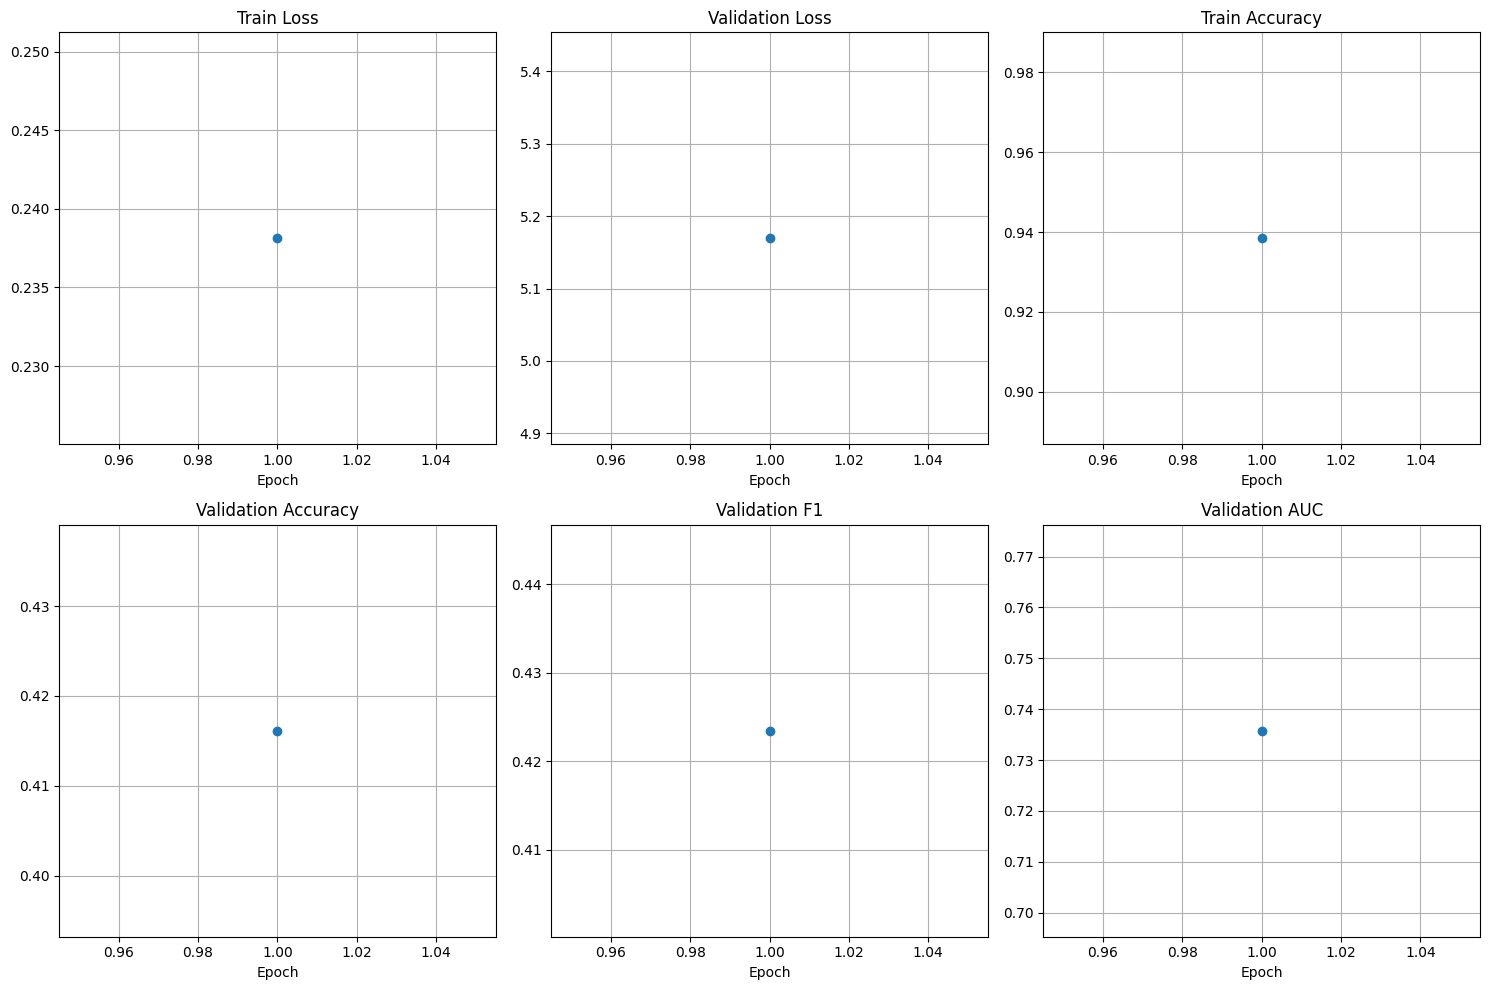

Epoch 2/20: 100%|██████████| 38624/38624 [05:14<00:00, 122.80it/s]


Epoch 2/20 | Train Loss=0.0810, Train Acc=0.9818 | Val Loss=487.7524, Val Acc=0.3415 | Val F1=0.2355 | AUC=0.5087


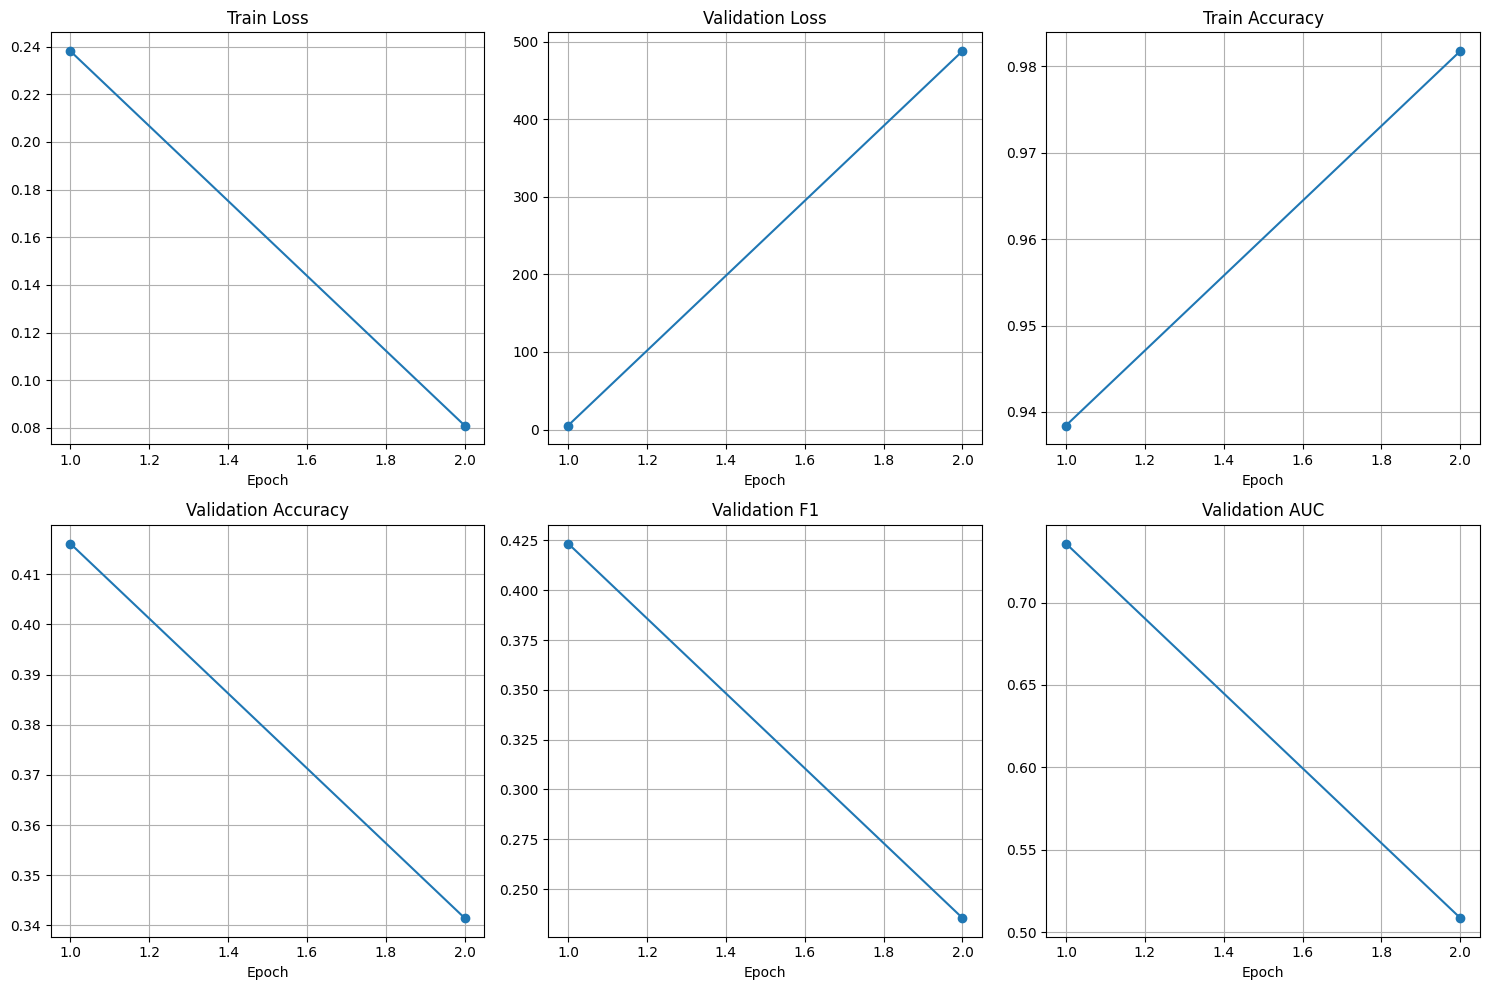

Epoch 3/20: 100%|██████████| 38624/38624 [04:02<00:00, 159.19it/s]


Epoch 3/20 | Train Loss=0.0377, Train Acc=0.9934 | Val Loss=6.0679, Val Acc=0.3454 | Val F1=0.2680 | AUC=0.5539


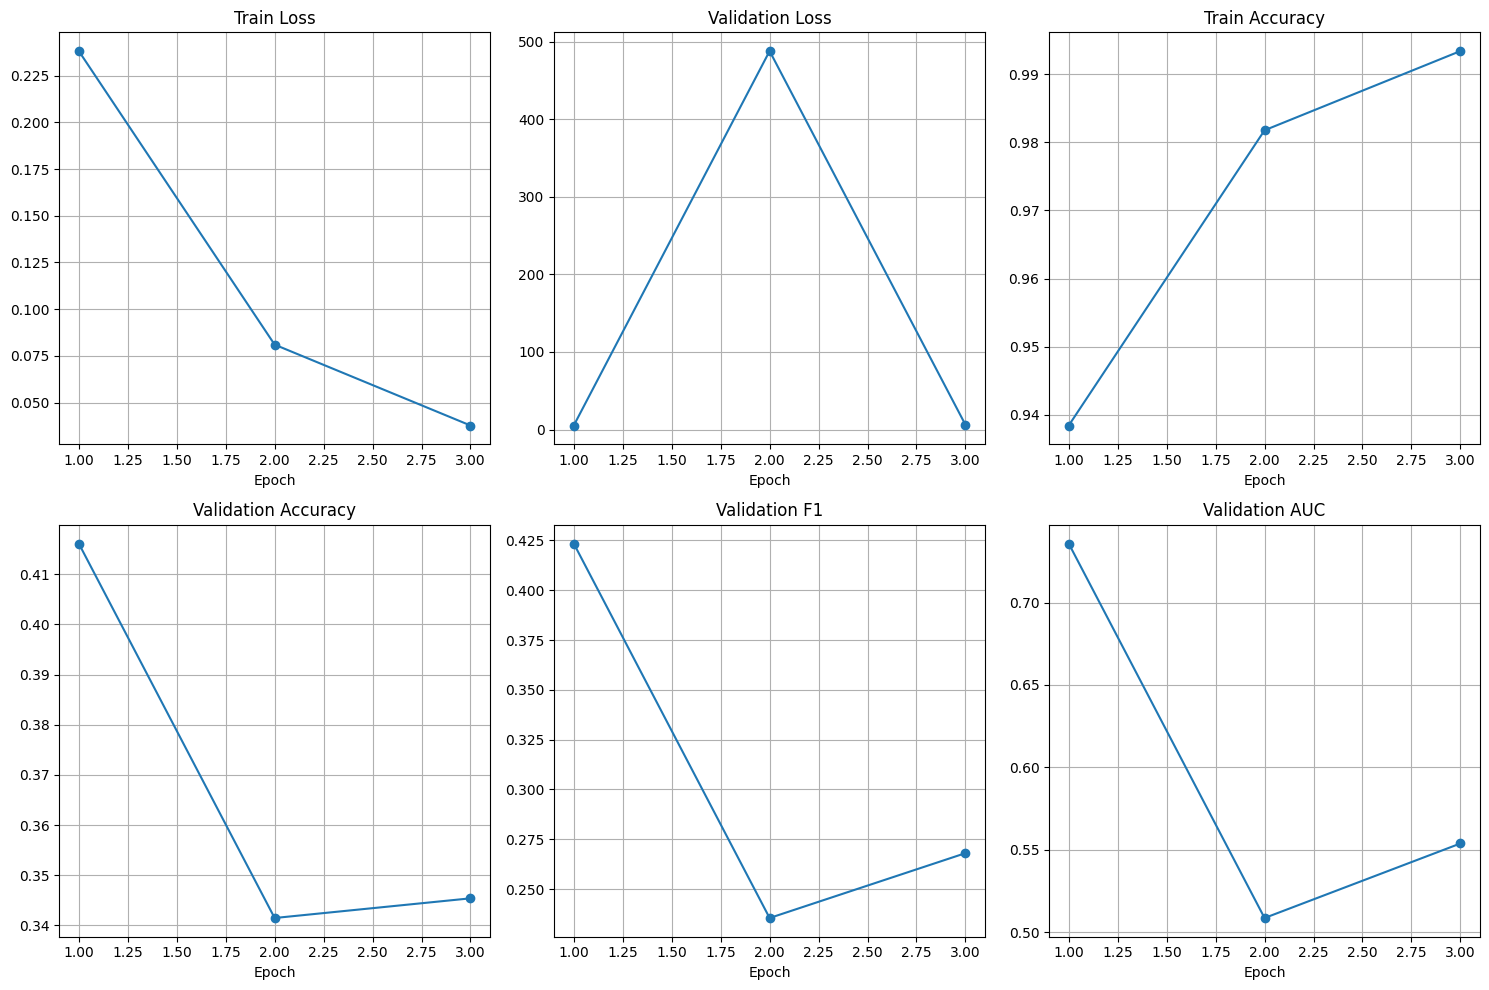

Epoch 4/20: 100%|██████████| 38624/38624 [04:04<00:00, 158.07it/s]


Epoch 4/20 | Train Loss=0.0231, Train Acc=0.9959 | Val Loss=8.8690, Val Acc=0.5591 | Val F1=0.5949 | AUC=0.7488


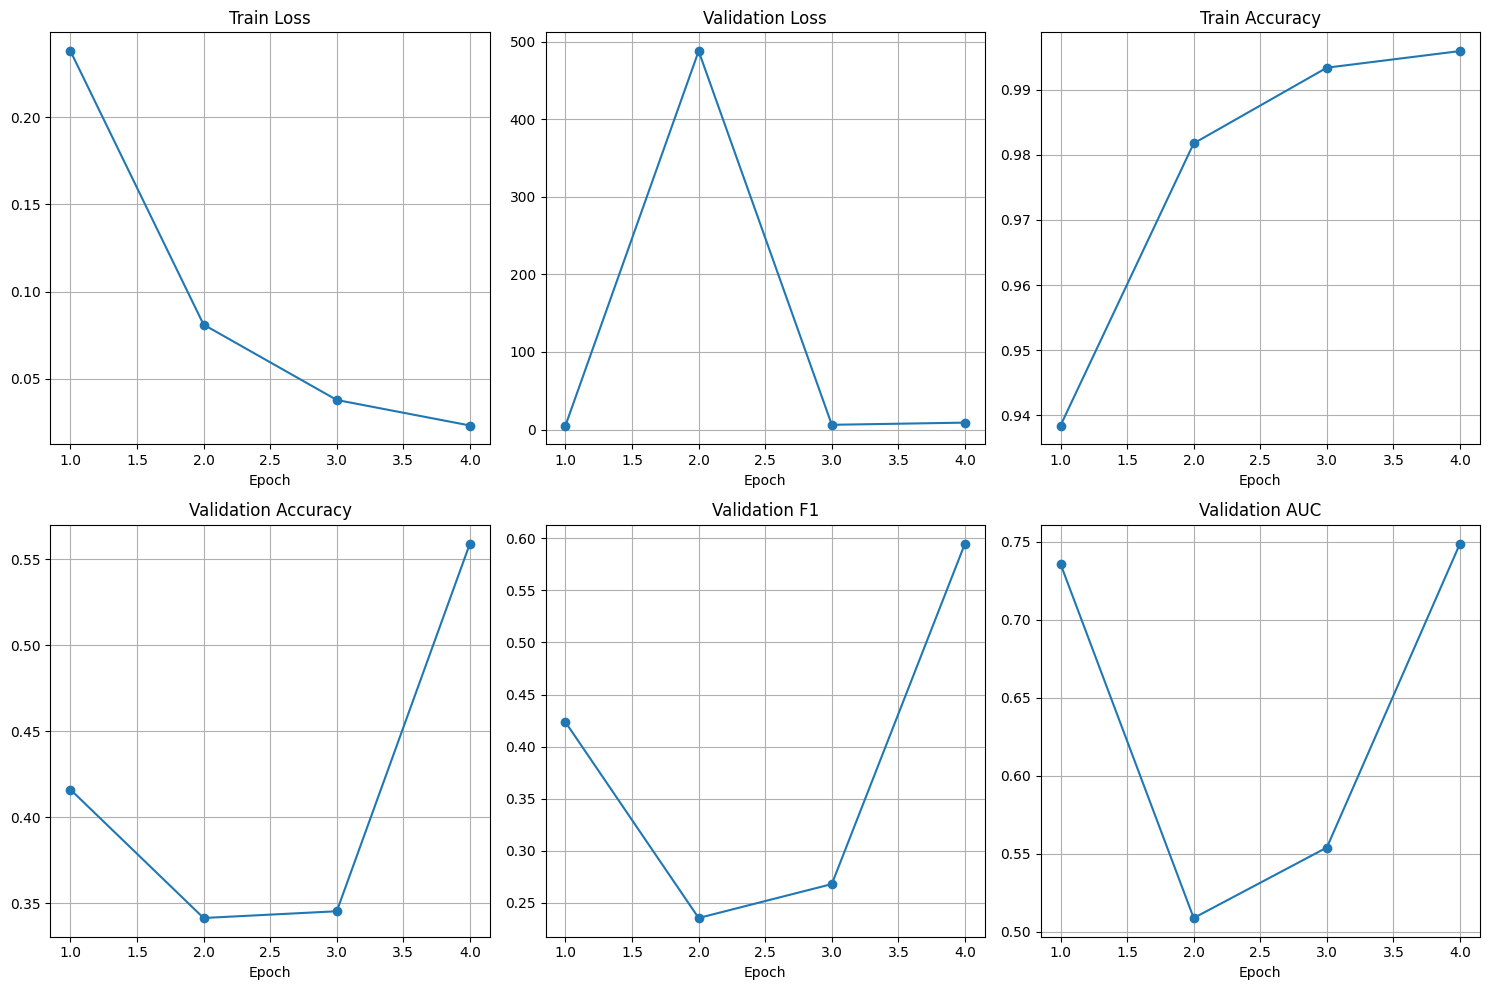

Epoch 5/20: 100%|██████████| 38624/38624 [04:06<00:00, 156.75it/s]


Epoch 5/20 | Train Loss=0.0194, Train Acc=0.9968 | Val Loss=3299.5412, Val Acc=0.2872 | Val F1=0.1077 | AUC=0.6660


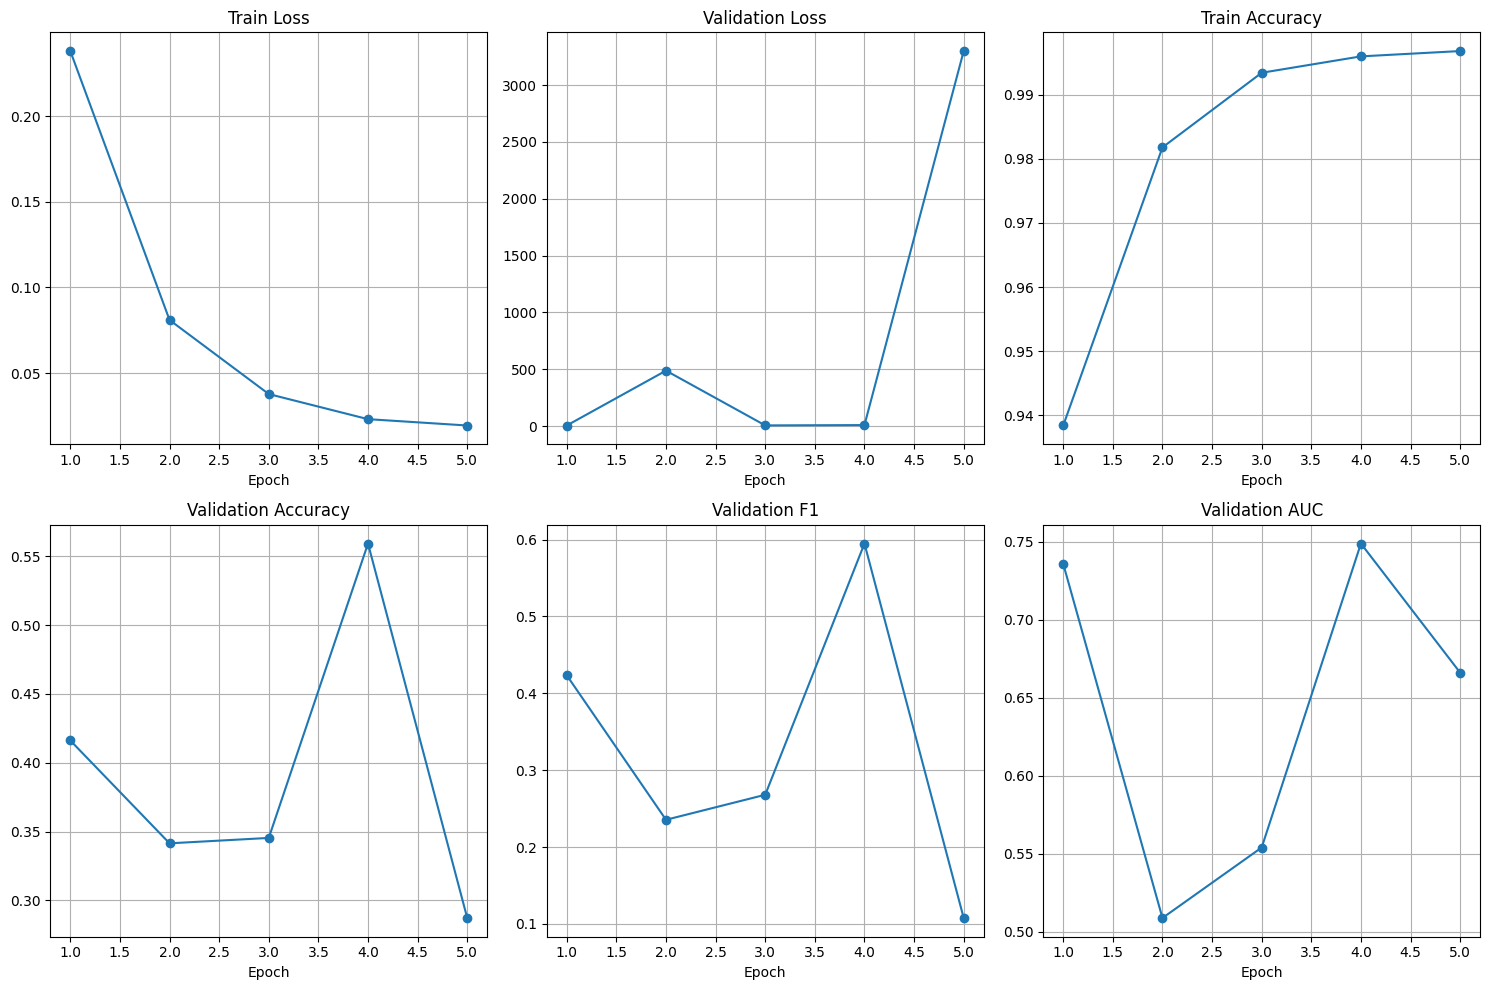

Epoch 6/20: 100%|██████████| 38624/38624 [04:01<00:00, 159.88it/s]


Epoch 6/20 | Train Loss=0.0170, Train Acc=0.9971 | Val Loss=38.8466, Val Acc=0.2836 | Val F1=0.0501 | AUC=0.3075


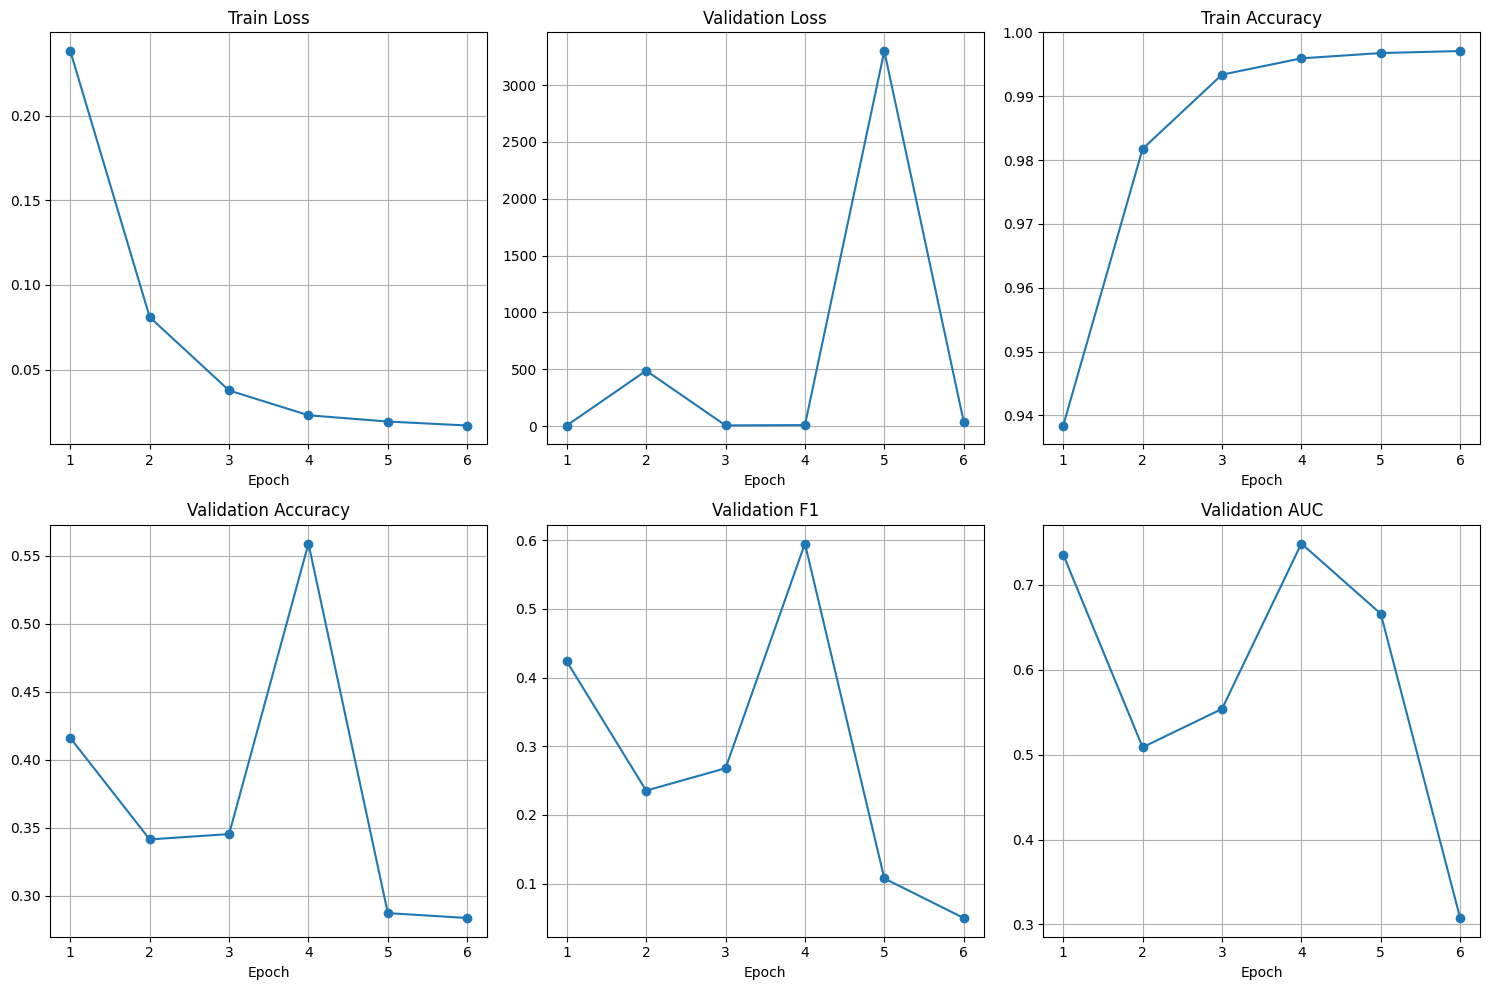

Epoch 7/20: 100%|██████████| 38624/38624 [04:07<00:00, 156.02it/s]


Epoch 7/20 | Train Loss=0.0187, Train Acc=0.9969 | Val Loss=11.8634, Val Acc=0.2723 | Val F1=0.0234 | AUC=0.2685


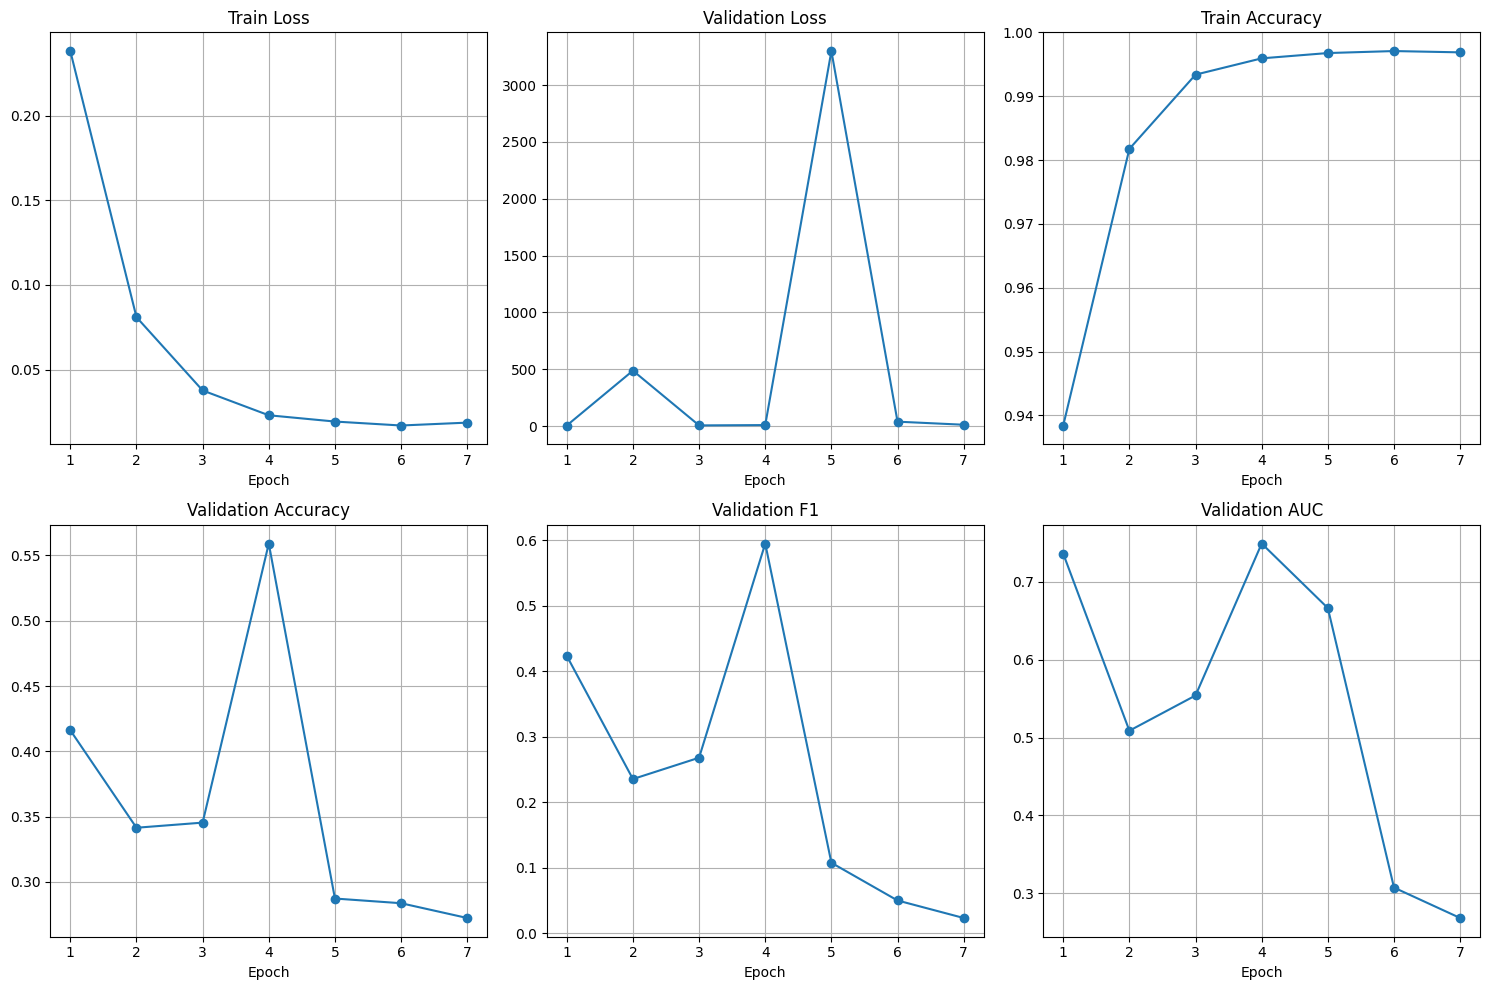

Epoch 8/20: 100%|██████████| 38624/38624 [04:04<00:00, 157.87it/s]


Epoch 8/20 | Train Loss=0.0183, Train Acc=0.9971 | Val Loss=10.5846, Val Acc=0.2722 | Val F1=0.0077 | AUC=0.3841


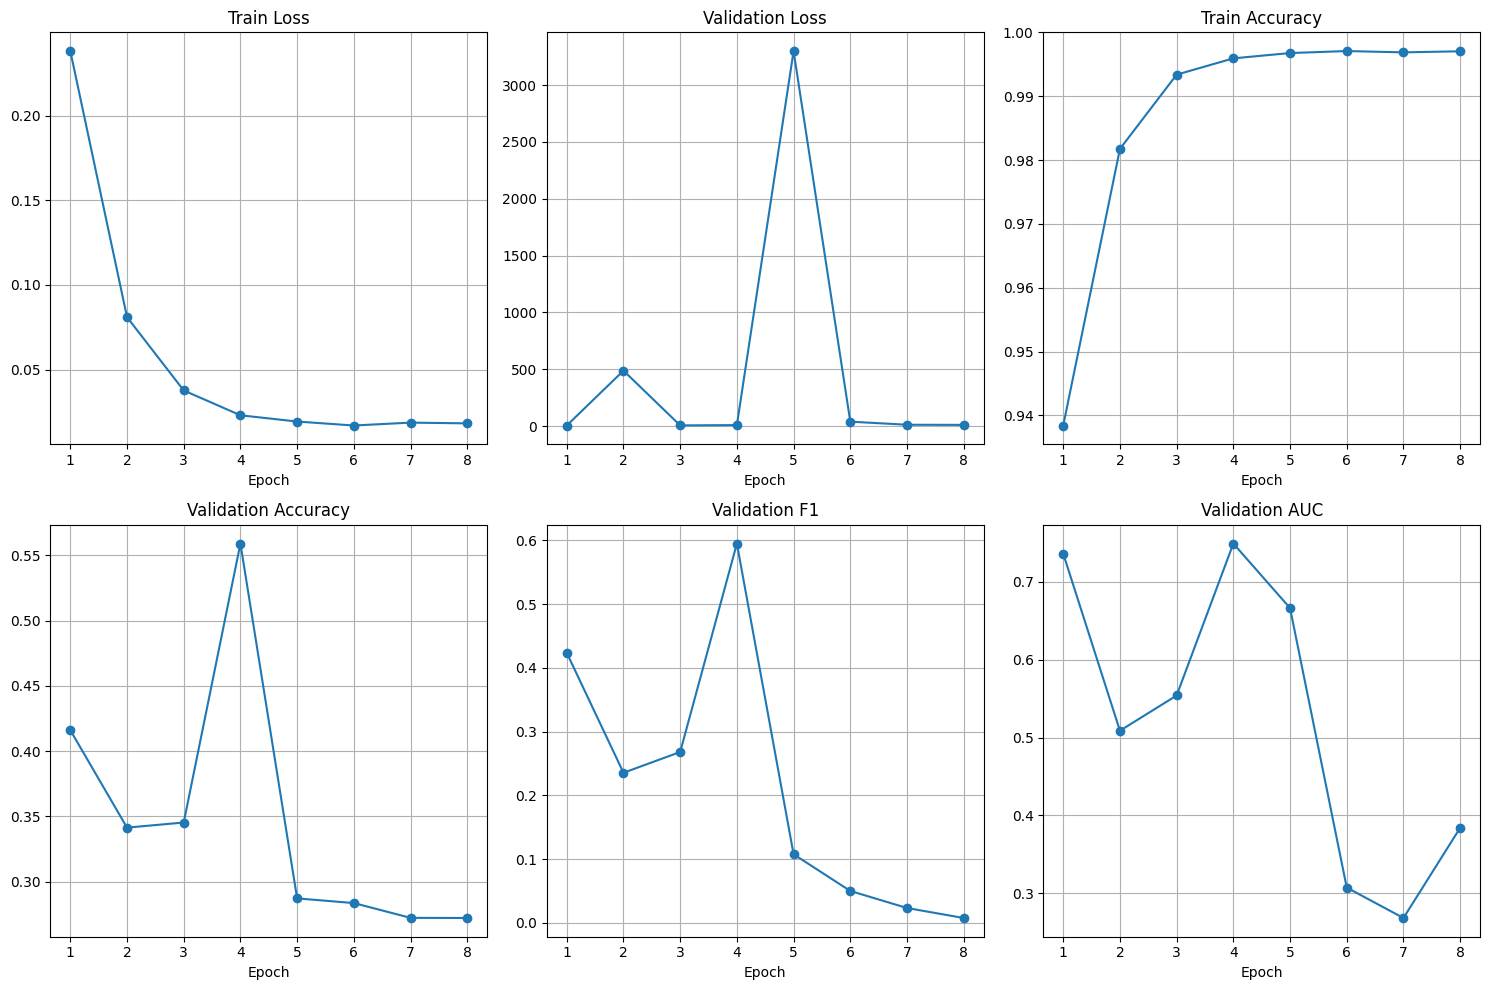

Epoch 9/20: 100%|██████████| 38624/38624 [03:48<00:00, 169.00it/s]


Epoch 9/20 | Train Loss=0.0139, Train Acc=0.9978 | Val Loss=23.5261, Val Acc=0.2722 | Val F1=0.0442 | AUC=0.3759


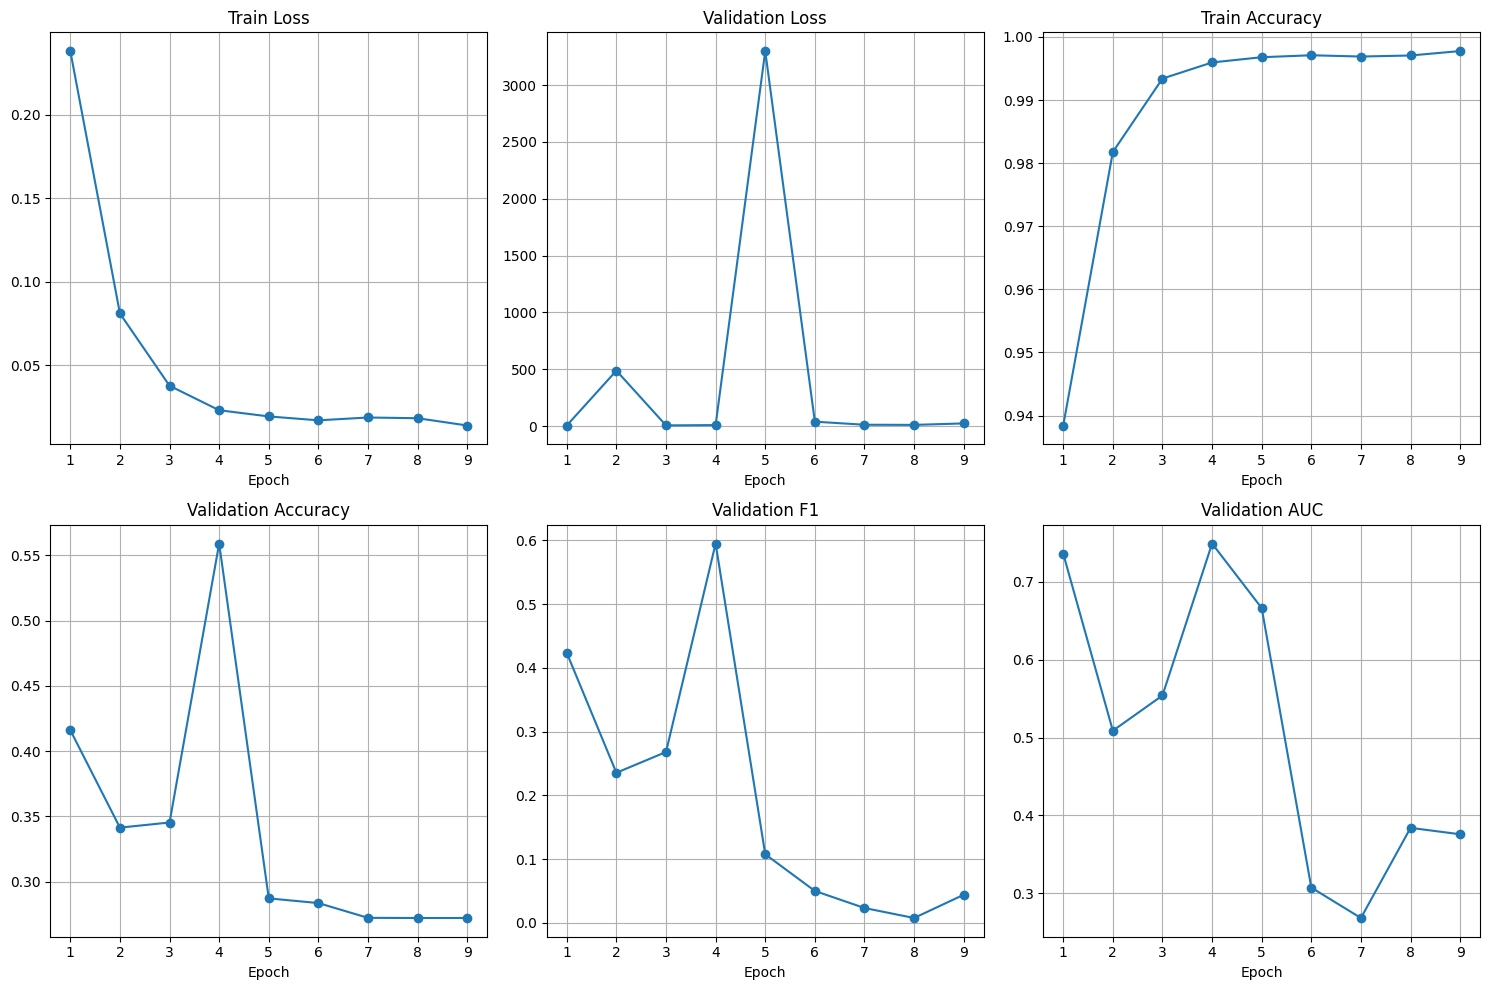

Epoch 10/20: 100%|██████████| 38624/38624 [03:48<00:00, 169.27it/s]


Epoch 10/20 | Train Loss=0.0126, Train Acc=0.9979 | Val Loss=61.0870, Val Acc=0.2755 | Val F1=0.0383 | AUC=0.3387


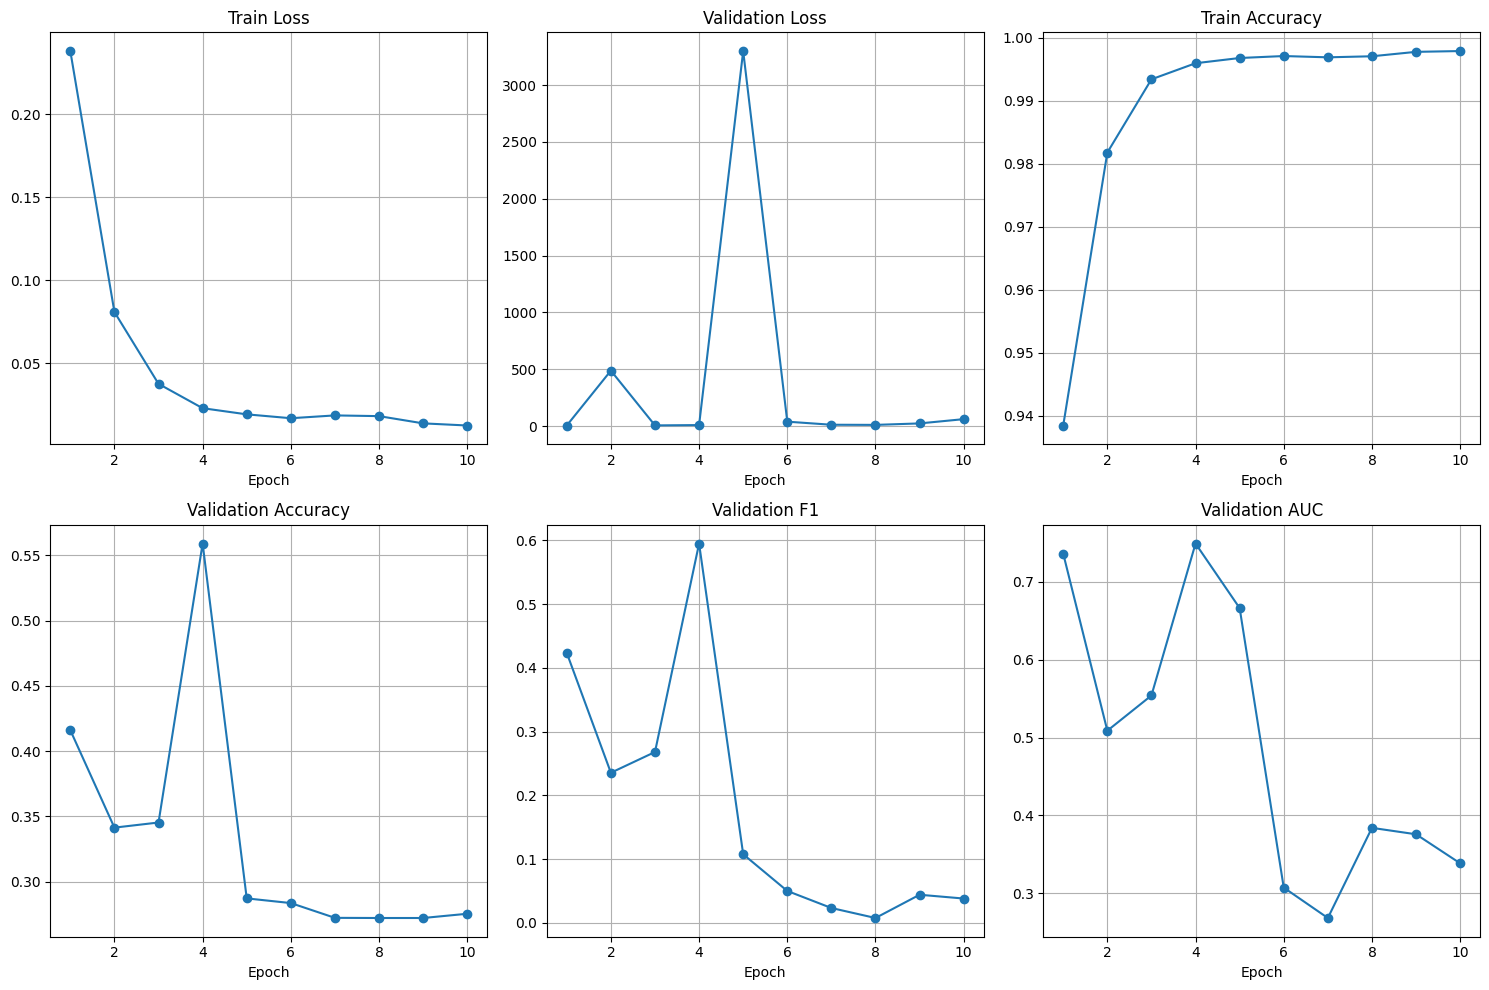

Epoch 11/20: 100%|██████████| 38624/38624 [04:03<00:00, 158.87it/s]


Epoch 11/20 | Train Loss=0.0126, Train Acc=0.9979 | Val Loss=277.1629, Val Acc=0.2722 | Val F1=0.1377 | AUC=0.4938


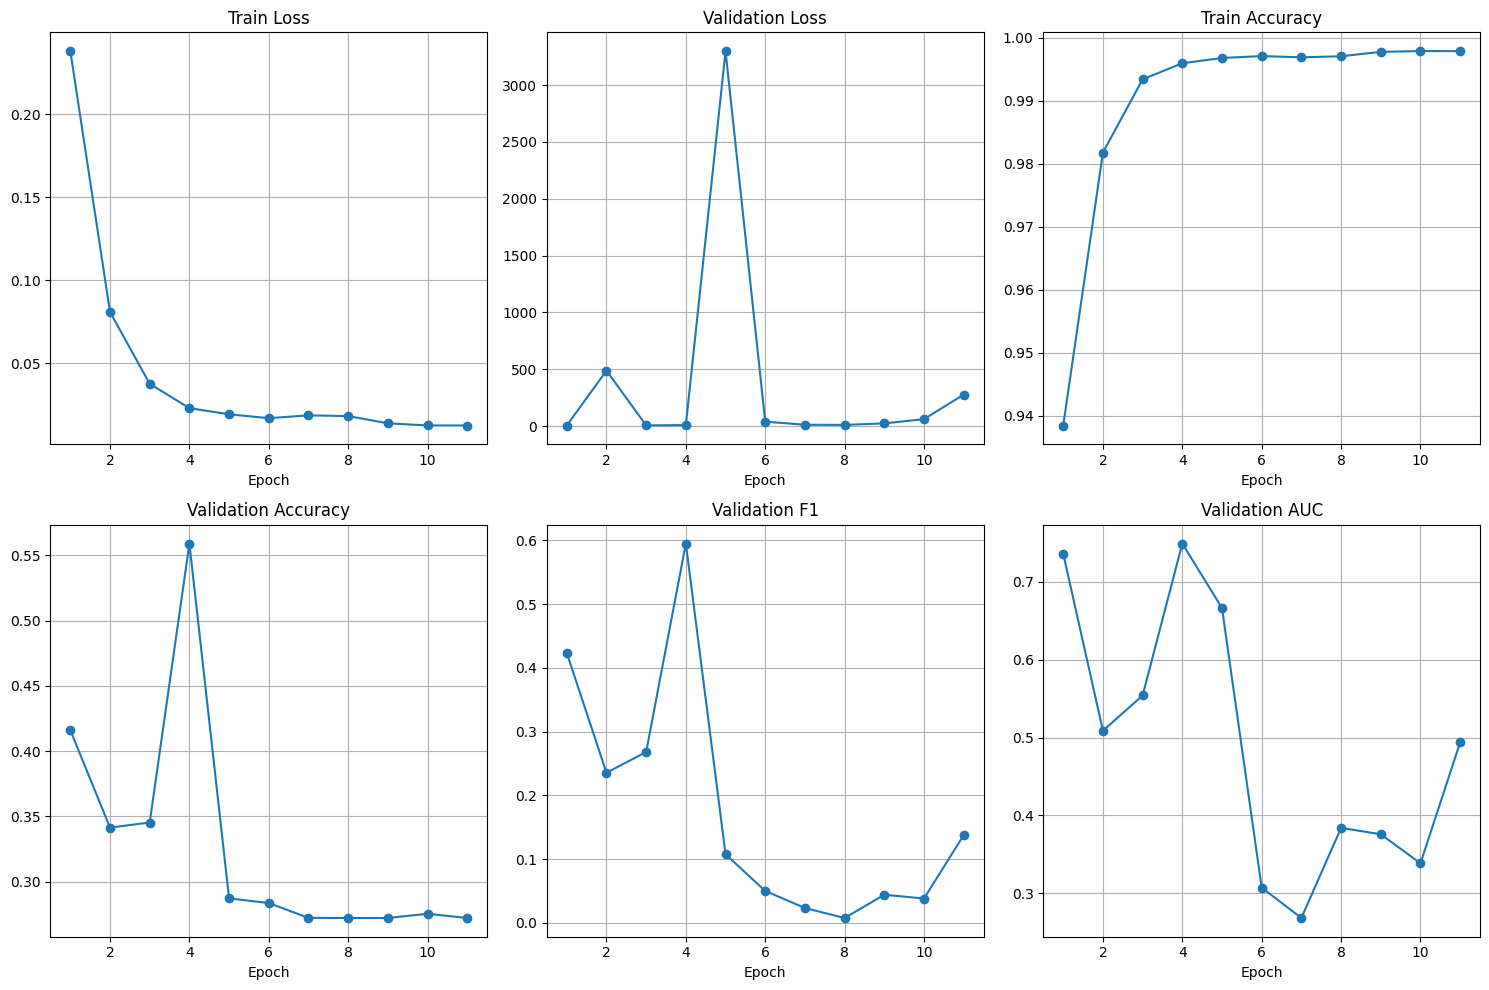

Epoch 12/20: 100%|██████████| 38624/38624 [03:53<00:00, 165.12it/s]


Epoch 12/20 | Train Loss=0.0127, Train Acc=0.9979 | Val Loss=161.6642, Val Acc=0.2725 | Val F1=0.4310 | AUC=0.5537


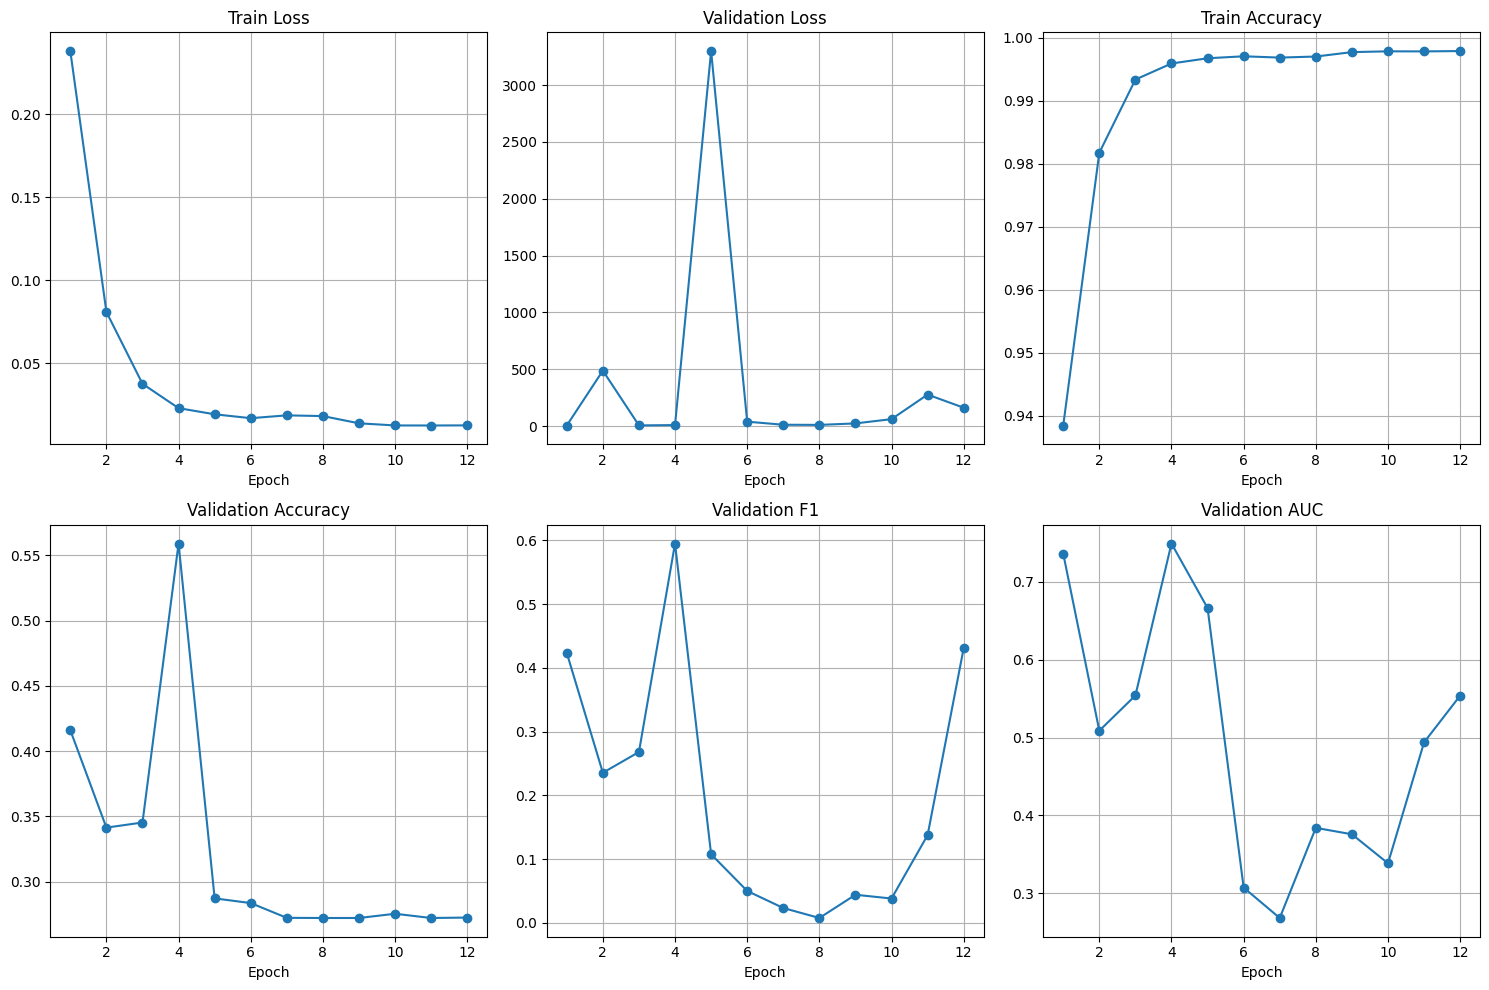

Epoch 13/20: 100%|██████████| 38624/38624 [03:55<00:00, 163.88it/s]


Epoch 13/20 | Train Loss=0.0121, Train Acc=0.9980 | Val Loss=50.9889, Val Acc=0.2726 | Val F1=0.0440 | AUC=0.3145


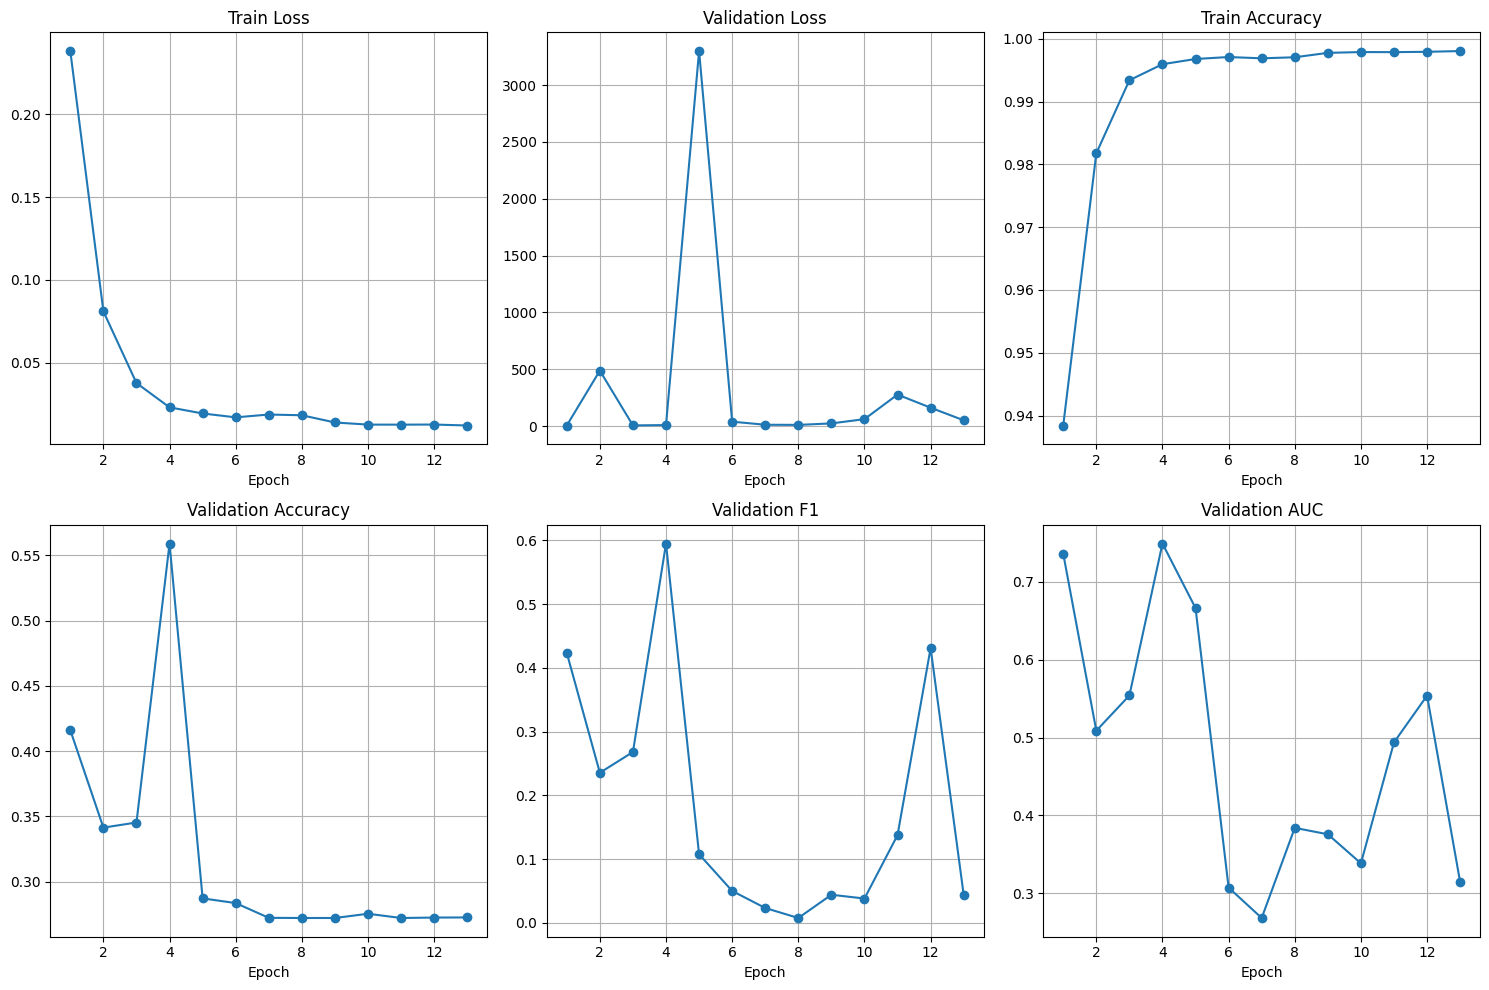

Epoch 14/20: 100%|██████████| 38624/38624 [03:56<00:00, 163.35it/s]


Epoch 14/20 | Train Loss=0.0111, Train Acc=0.9981 | Val Loss=182.9017, Val Acc=0.2726 | Val F1=0.0207 | AUC=0.3824
⏹ Early stopping at epoch 14


In [21]:
# ==============================
# STEP 7: ENHANCED LSTM TRAINING with tqdm + GPU check
# ==============================
print("\n=== STEP 7: Enhanced LSTM Training with Comprehensive Monitoring ===")

# Create model with debugging
final_model = AdvancedLSTM(
    input_dim=X_train_seq.shape[2],
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    use_attention=best_params.get('use_attention', False),
    bidirectional=best_params.get('bidirectional', False)
).to(device)

total_params = sum(p.numel() for p in final_model.parameters())
print(f"Model parameters: {total_params:,}")

# ✅ GPU sanity check
print(f"Using device: {device}")
try:
    test_tensor = torch.rand(10).to(device)
    print(f"Tensor successfully moved to {device}: {test_tensor.device}")
except Exception as e:
    print(f"⚠️ Could not allocate tensor on device {device}: {e}")

# Patch train_advanced_lstm_enhanced_debug to include tqdm
import matplotlib.pyplot as plt

def train_advanced_lstm_enhanced_debug(X_train, y_train, X_val, y_val,
                                        params, model, epochs=20, verbose=True):

    X_train = X_train.astype(np.float32)
    X_val   = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val   = y_val.astype(np.float32)

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(
        train_dataset,
        batch_size=params.get('batch_size', 256),
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params.get('batch_size', 256),
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([params.get('pos_weight', 1.0)], device=device)
    )

    # Metric trackers
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_aucs, val_f1s = [], []

    best_val_f1, patience_counter = 0, 0
    patience = params.get('early_stopping_patience', 10)
    best_state = None

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

            preds = (torch.sigmoid(outputs) >= 0.5).int()
            correct += (preds.squeeze() == y_batch.int()).sum().item()
            total += y_batch.size(0)

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(correct / total if total > 0 else 0)

        # ---- Validation ----
        model.eval()
        val_probs, val_targets = [], []
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)

                val_probs.extend(probs)
                val_targets.extend(y_batch.cpu().numpy())

                val_correct += (preds.squeeze() == y_batch.cpu().int().numpy()).sum()
                val_total += y_batch.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_correct / val_total if val_total > 0 else 0)

        val_probs = np.array(val_probs).flatten()
        val_targets = np.array(val_targets)

        try:
            val_auc = roc_auc_score(val_targets, val_probs)
        except:
            val_auc = 0.5

        thresholds = np.linspace(0.1, 0.9, 20)
        f1_scores = [f1_score(val_targets, (val_probs >= t).astype(int)) for t in thresholds]
        best_f1 = max(f1_scores) if f1_scores else 0

        val_aucs.append(val_auc)
        val_f1s.append(best_f1)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss={avg_loss:.4f}, Train Acc={train_accs[-1]:.4f} | "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_accs[-1]:.4f} | "
                  f"Val F1={best_f1:.4f} | AUC={val_auc:.4f}")

        # ---- Early stopping ----
        if best_f1 > best_val_f1:
            best_val_f1 = best_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break

        # ---- Plot after each epoch ----
        plt.figure(figsize=(15, 10))

        metrics = [
            ("Train Loss", train_losses),
            ("Validation Loss", val_losses),
            ("Train Accuracy", train_accs),
            ("Validation Accuracy", val_accs),
            ("Validation F1", val_f1s),
            ("Validation AUC", val_aucs),
        ]

        for i, (title, values) in enumerate(metrics, 1):
            plt.subplot(2, 3, i)
            plt.plot(range(1, len(values)+1), values, marker='o')
            plt.title(title)
            plt.xlabel("Epoch")
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return model, train_losses, val_losses, train_accs, val_accs, val_aucs, val_f1s

# finally call training
final_model, train_losses, val_aucs, val_f1s, training_info, val_aucs, val_f1s = train_advanced_lstm_enhanced_debug(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, best_params, final_model,
    epochs=20, verbose=True
)

In [ ]:
# ==============================
# STEP 8: Comprehensive Evaluation with Debugging
# ==============================
print("\n=== STEP 8: Final Model Evaluation with Debugging ===")
    
try:
    # Test evaluation with debugging
    test_dataset = TensorDataset(torch.FloatTensor(X_test_seq), torch.FloatTensor(y_test_seq))
    test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test_seq)), shuffle=False)
        
    final_model.eval()
    test_probs = []
    test_targets = []
    all_outputs = []
        
    print("Evaluating model on test set...")
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(test_loader):
            batch_X = batch_X.to(device)
            outputs = final_model(batch_X)
                
            # Debug model outputs
            if i == 0:  # First batch debugging
                print(f"First batch outputs shape: {outputs.shape}")
                print(f"Output range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
                print(f"Output mean: {outputs.mean().item():.4f}")
                print(f"Output std: {outputs.std().item():.4f}")
                
            all_outputs.extend(outputs.cpu().numpy())
                
            if not torch.isnan(outputs).any() and not torch.isinf(outputs).any():
                probs = torch.sigmoid(outputs).cpu().numpy()
                test_probs.extend(probs)
                test_targets.extend(batch_y.numpy())
            else:
                print(f"⚠️  NaN or Inf detected in batch {i}")
        
    test_probs = np.array(test_probs).flatten()
    test_targets = np.array(test_targets)
    all_outputs = np.array(all_outputs).flatten()
        
    print(f"\nModel output analysis:")
    print(f"Raw outputs - Min: {all_outputs.min():.4f}, Max: {all_outputs.max():.4f}")
    print(f"Raw outputs - Mean: {all_outputs.mean():.4f}, Std: {all_outputs.std():.4f}")
    print(f"Probabilities - Min: {test_probs.min():.4f}, Max: {test_probs.max():.4f}")
    print(f"Probabilities - Mean: {test_probs.mean():.4f}, Std: {test_probs.std():.4f}")
        
    # Check for constant predictions
    if test_probs.std() < 1e-6:
        print("🚨 CRITICAL ISSUE: Model is making constant predictions!")
        print("   All probabilities are essentially the same")
        print("   This explains the stagnant metrics")
        print("   Model failed to learn meaningful patterns")
        
    # Find optimal threshold
    if len(np.unique(test_targets)) > 1 and test_probs.std() > 1e-6:
        thresholds = np.linspace(0.01, 0.99, 100)
        f1_scores = []
        for t in thresholds:
            preds = (test_probs >= t).astype(int)
            f1 = f1_score(test_targets, preds, zero_division=0)
            f1_scores.append(f1)
            
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_threshold_idx]
        best_f1 = f1_scores[best_threshold_idx]
            
        print(f"Threshold optimization:")
        print(f"  Best threshold: {best_threshold:.4f}")
        print(f"  Best F1 at threshold: {best_f1:.4f}")
    else:
        best_threshold = 0.5
        print("Using default threshold: 0.5")
        
    y_pred_final = (test_probs >= best_threshold).astype(int)
        
    # Calculate metrics with debugging
    print(f"\nPrediction analysis:")
    pred_unique, pred_counts = np.unique(y_pred_final, return_counts=True)
    print(f"Predictions distribution: {dict(zip(pred_unique, pred_counts))}")
    target_unique, target_counts = np.unique(test_targets, return_counts=True)
    print(f"Targets distribution: {dict(zip(target_unique, target_counts))}")
        
    # Calculate metrics
    lstm_results = {
        'accuracy': accuracy_score(test_targets, y_pred_final),
        'f1': f1_score(test_targets, y_pred_final, zero_division=0),
        'precision': precision_score(test_targets, y_pred_final, zero_division=0),
        'recall': recall_score(test_targets, y_pred_final, zero_division=0),
        'best_threshold': best_threshold
    }
        
    if len(np.unique(test_targets)) > 1 and test_probs.std() > 1e-6:
        try:
            lstm_results['auc'] = roc_auc_score(test_targets, test_probs)
            lstm_results['pr_auc'] = average_precision_score(test_targets, test_probs)
        except:
            lstm_results['auc'] = 0.5
            lstm_results['pr_auc'] = 0.5
            print("⚠️  Could not calculate AUC scores")
    else:
        lstm_results['auc'] = 0.5
        lstm_results['pr_auc'] = 0.5
        
    print(f"\n=== Chronological LSTM Results ===")
    print(f"Accuracy:  {lstm_results['accuracy']:.4f}")
    print(f"AUC:       {lstm_results['auc']:.4f}")
    print(f"F1 Score:  {lstm_results['f1']:.4f}")
    print(f"Precision: {lstm_results['precision']:.4f}")
    print(f"Recall:    {lstm_results['recall']:.4f}")
        
    # Enhanced reality check
    if lstm_results['f1'] == 0:
        print("\n🚨 CRITICAL ISSUE: F1 Score is 0!")
        print("   This indicates complete prediction failure")
        print("   Check model architecture and training process")
    elif lstm_results['f1'] < 0.1:
        print("\n🚨 Very poor performance - model barely learning")
    elif lstm_results['f1'] > 0.98:
        print("\n🚨 SUSPICIOUSLY HIGH PERFORMANCE!")
        print("   F1 > 0.98 suggests possible data leakage or unrealistic dataset")
    elif lstm_results['f1'] > 0.95:
        print("\n⚠️  Very high performance - double-check for issues")
    else:
        print("\n✅ Realistic performance range")
            
except Exception as e:
    print(f"Evaluation failed: {e}")
    import traceback
    traceback.print_exc()
    lstm_results = {'f1': 0.0, 'auc': 0.5}


=== STEP 8: Final Model Evaluation with Debugging ===
Evaluating model on test set...
First batch outputs shape: torch.Size([64])
Output range: [-149.4618, -28.7667]
Output mean: -51.5637
Output std: 39.8599

Model output analysis:
Raw outputs - Min: -173.6059, Max: 99.3688
Raw outputs - Mean: -36.9380, Std: 43.5214
Probabilities - Min: 0.0000, Max: 1.0000
Probabilities - Mean: 0.2068, Std: 0.4039
Threshold optimization:
  Best threshold: 0.9900
  Best F1 at threshold: 0.9505

Prediction analysis:
Predictions distribution: {np.int64(0): np.int64(85660), np.int64(1): np.int64(21931)}
Targets distribution: {np.float32(0.0): np.int64(87524), np.float32(1.0): np.int64(20067)}

=== Chronological LSTM Results ===
Accuracy:  0.9807
AUC:       0.9989
F1 Score:  0.9505
Precision: 0.9101
Recall:    0.9946

⚠️  Very high performance - double-check for issues


In [22]:
# ==============================
# STEP 9: Enhanced Diagnostics and Recommendations
# ==============================
print("\n" + "="*50)
print("ENHANCED DIAGNOSTICS AND RECOMMENDATIONS")
print("="*50)
    
# Diagnose the root cause of stagnant metrics
print("\n🔍 ROOT CAUSE ANALYSIS:")
    
if lstm_results.get('f1', 0) == 0:
    print("❌ ISSUE 1: Zero F1 Score")
    print("   Causes: Model predicting single class OR complete mismatch")
    print("   Solutions:")
    print("   - Check class distribution in sequences")
    print("   - Adjust loss function (use focal loss or class weights)")
    print("   - Try different sequence labeling strategy")
    print("   - Increase learning rate")
    
elif len(val_f1s) > 5 and np.var(val_f1s) < 1e-6:
    print("❌ ISSUE 2: Stagnant Validation Metrics")
    print("   Causes: Model not learning OR constant predictions")
    print("   Solutions:")
    print("   - Check gradient flow (gradient norms)")
    print("   - Increase learning rate (try 1e-3 or 1e-2)")
    print("   - Reduce model complexity if overfitting")
    print("   - Check for vanishing gradients")
    print("   - Try different activation functions")
    
elif 'test_probs' in locals() and test_probs.std() < 1e-6:
    print("❌ ISSUE 3: Constant Model Predictions")
    print("   Causes: Model stuck in local minimum OR poor initialization")
    print("   Solutions:")
    print("   - Reinitialize model weights")
    print("   - Use Xavier/He initialization")
    print("   - Try different optimizer (SGD with momentum)")
    print("   - Increase batch size")
    print("   - Check input data preprocessing")
    
# Data-related issues
if attack_ratio < 0.01 or attack_ratio > 0.99:
    print("❌ ISSUE 4: Severe Class Imbalance")
    print("   Solutions:")
    print("   - Use weighted loss function (implemented)")
    print("   - Try focal loss for extreme imbalance")
    print("   - Use SMOTE or other resampling techniques")
    print("   - Adjust decision threshold")
    
# Architecture issues
if complexity_ratio > 0.2:
    print("❌ ISSUE 5: Model Too Complex")
    print("   Solutions:")
    print("   - Reduce hidden dimensions")
    print("   - Reduce number of layers")
    print("   - Increase regularization")
    
# Compare with baselines
lstm_f1 = lstm_results.get('f1', 0)
best_baseline_f1 = baseline_results_df['F1'].max() if len(baseline_results_df) > 0 else 0
    
print(f"\n📊 Performance Comparison:")
print(f"Best Baseline F1: {best_baseline_f1:.4f}")
print(f"Chronological LSTM F1: {lstm_f1:.4f}")
    
if lstm_f1 > 0:
    improvement = ((lstm_f1 / best_baseline_f1) - 1) * 100 if best_baseline_f1 > 0 else float('inf')
    print(f"Improvement: {improvement:.1f}%")
else:
    print("Improvement: N/A (LSTM failed)")
    
print(f"\n🕒 Temporal Integrity: ✅ MAINTAINED")
print(f"   - Chronological data splitting")
print(f"   - No future information leakage")
print(f"   - Realistic evaluation protocol")
    
print(f"\n📋 SPECIFIC RECOMMENDATIONS:")
    
if lstm_f1 == 0:
    print("🚨 IMMEDIATE ACTIONS NEEDED:")
    print("1. Check data preprocessing - verify both classes exist in sequences")
    print("2. Try simpler model first (single LSTM layer, hidden_dim=32)")
    print("3. Use class weights in loss function")
    print("4. Start with higher learning rate (1e-3)")
    print("5. Debug gradient flow - print gradient norms during training")
        
elif lstm_f1 < 0.1:
    print("⚠️  POOR PERFORMANCE - TRY:")
    print("1. Increase learning rate to 1e-3 or 5e-3")
    print("2. Reduce model complexity")
    print("3. Check for gradient vanishing")
    print("4. Try different loss function (focal loss)")
    print("5. Verify input data normalization")
        
elif lstm_f1 < best_baseline_f1:
    print("📉 UNDERPERFORMING BASELINES:")
    print("1. LSTM may be overkill for this dataset")
    print("2. Try reducing sequence length")
    print("3. Consider using baseline model instead")
    print("4. Check if temporal patterns actually exist in data")
        
else:
    print("✅ PERFORMANCE ACCEPTABLE:")
    print("1. Monitor for overfitting in production")
    print("2. Consider ensemble methods")
    print("3. Fine-tune hyperparameters")
        
# Additional debugging suggestions
print(f"\n🛠️  DEBUGGING CHECKLIST:")
print("□ Verify both classes exist in training sequences")
print("□ Check gradient norms during training")
print("□ Monitor loss convergence")
print("□ Verify model outputs are changing")
print("□ Test with different sequence lengths")
print("□ Try different optimizers (Adam vs SGD)")
print("□ Check for NaN/Inf in inputs")
print("□ Verify loss function implementation")


def train_advanced_lstm_enhanced_debug(X_train, y_train, X_val, y_val, params, model, epochs=50, verbose=True):
    """
    Enhanced training function with comprehensive debugging
    """
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.metrics import f1_score, roc_auc_score
    import numpy as np

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)), shuffle=False)

    # Setup loss function with class weights
    pos_weight = torch.tensor(params.get('pos_weight', 1.0)).to(device)

    if params.get('focal_loss', False):
        # Implement focal loss for severe class imbalance
        class FocalLoss(nn.Module):
            def __init__(self, alpha=1, gamma=2, pos_weight=1.0):
                super().__init__()
                self.alpha = alpha
                self.gamma = gamma
                self.pos_weight = pos_weight
                
            def forward(self, inputs, targets):
                bce_loss = nn.functional.binary_cross_entropy_with_logits(
                    inputs, targets, pos_weight=torch.tensor(self.pos_weight).to(inputs.device)
                )
                pt = torch.exp(-bce_loss)
                focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
                return focal_loss.mean()
        
        criterion = FocalLoss(pos_weight=pos_weight.item())
        print(f"Using Focal Loss with pos_weight={pos_weight.item():.2f}")
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print(f"Using BCE Loss with pos_weight={pos_weight.item():.2f}")

    # Setup optimizer
    if params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=params.get('l2_reg', 1e-4)
        )
    else:
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=params['lr'], 
            momentum=0.9,
            weight_decay=params.get('l2_reg', 1e-4)
        )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.5, 
        patience=params.get('reduce_lr_patience', 5),
        min_lr=params.get('min_lr', 1e-6),
        verbose=True
    )

    # Training tracking
    train_losses = []
    val_aucs = []
    val_f1s = []
    best_val_f1 = 0
    patience_counter = 0
    training_info = {'grad_norms': [], 'lr_history': []}

    print(f"Starting training for {epochs} epochs...")
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_losses = []
        epoch_grad_norms = []
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            
            # Debug: Check for NaN/Inf in outputs
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                print(f"⚠️  NaN/Inf detected in outputs at epoch {epoch}, batch {batch_idx}")
                continue
            
            loss = criterion(outputs.squeeze(), batch_y)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️  NaN/Inf detected in loss at epoch {epoch}, batch {batch_idx}")
                continue
            
            loss.backward()
            
            # Gradient clipping and monitoring
            if params.get('gradient_clip', 0) > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clip'])
            
            # Monitor gradient norms
            grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    grad_norm += p.grad.data.norm(2).item() ** 2
            grad_norm = grad_norm ** 0.5
            epoch_grad_norms.append(grad_norm)
            
            optimizer.step()
            epoch_losses.append(loss.item())
        
        if len(epoch_losses) == 0:
            print(f"⚠️  No valid batches in epoch {epoch}")
            continue
            
        avg_train_loss = np.mean(epoch_losses)
        avg_grad_norm = np.mean(epoch_grad_norms)
        train_losses.append(avg_train_loss)
        training_info['grad_norms'].append(avg_grad_norm)
        training_info['lr_history'].append(optimizer.param_groups[0]['lr'])
        
        # Validation phase
        model.eval()
        val_probs = []
        val_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                
                if not torch.isnan(outputs).any():
                    probs = torch.sigmoid(outputs).cpu().numpy()
                    val_probs.extend(probs)
                    val_targets.extend(batch_y.numpy())
        
        if len(val_probs) > 0:
            val_probs = np.array(val_probs).flatten()
            val_targets = np.array(val_targets)
            
            # Calculate metrics
            val_preds = (val_probs >= 0.5).astype(int)
            val_f1 = f1_score(val_targets, val_preds, zero_division=0)
            
            try:
                val_auc = roc_auc_score(val_targets, val_probs) if len(np.unique(val_targets)) > 1 else 0.5
            except:
                val_auc = 0.5
            
            val_f1s.append(val_f1)
            val_aucs.append(val_auc)
            
            # Learning rate scheduling
            scheduler.step(val_f1)
            
            # Early stopping
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                patience_counter = 0
                # Save best model state
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:3d}: Loss={avg_train_loss:.4f}, "
                        f"Val F1={val_f1:.4f}, Val AUC={val_auc:.4f}, "
                        f"GradNorm={avg_grad_norm:.4f}, LR={optimizer.param_groups[0]['lr']:.2e}")
            
            # Debug stagnant metrics
            if epoch >= 10:
                recent_f1s = val_f1s[-5:]
                if len(recent_f1s) == 5 and np.std(recent_f1s) < 1e-6:
                    print(f"⚠️  Validation F1 stagnant for 5 epochs at {val_f1:.6f}")
                    if val_f1 < 0.1:
                        print("   Consider increasing learning rate or changing architecture")
            
            # Early stopping
            if patience_counter >= params.get('early_stopping_patience', 10):
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        else:
            print(f"⚠️  No valid validation predictions at epoch {epoch}")

    # Load best model
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")

    return model, train_losses, val_aucs, val_f1s, training_info



ENHANCED DIAGNOSTICS AND RECOMMENDATIONS

🔍 ROOT CAUSE ANALYSIS:


NameError: name 'lstm_results' is not defined

In [ ]:
def main_chr_debugged_v2(window_length):
    print("\n" + "="*70)
    print("DEBUGGED Chronologically-Aware Advanced LSTM for Network Intrusion Detection (v2 with Leak Checks)")
    print("="*70)
# ==============================
# Usage
# ==============================
if __name__ == "__main__":
    print("🚀 Running DEBUGGED LSTM with comprehensive monitoring...")
    print("This version includes:")
    print("- Enhanced class imbalance handling")
    print("- Gradient monitoring")
    print("- Output analysis")
    print("- Root cause diagnosis")
    print("- Specific recommendations")
    
    final_model1, X_test, y_test, probs, targets = main_chr_debugged_v2(1)
    
    if final_model1 is not None:
        print("\n" + "="*50)
        print("TRYING DIFFERENT SEQUENCE LENGTH...")
        print("="*50)
        final_model2, _, _, _, _ = main_chr_debugged_v2(8)